# Cadena de Ehrenfest
## Simulación

En este notebook simularemos el comportamiento de la urna de Ehrenfest.

- **Nico Quijada**
- **Celia Estrada**

## 1. Modelado

Primero modelaremos a la urna de Ehrenfest.

### Diseño de la matriz

Primero programaremos la matriz que modela al proceso.

In [25]:
#Importamos las bibliotecas necesarias
import numpy as np 
from numpy.linalg import matrix_power
import random
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
#Programación de la matriz
s = 20 #Definimos la cantidad de estados que irán en {0,..., s}
M = np.zeros((s+1,s+1)) #Creamos una matriz de ceros añadiendo una entrada para el estado 0.
for i in range(0, s): #Rellenamos la matriz con las probabilidades de transición calculadas
    M[i+1,i] = (i+1)/(s) #Bajo la diagonal
    M[i, i+1] = ((s)-i)/(s) #Sobre la diagonal

#Podemos descomentar la siguiente línea para observar la forma de la matriz.
#print(M)

### Simulación del proceso 
Obtenida la matriz, simulamos el proceso. Para ello requerimos dar una distribución inicial de probabilidad.


In [12]:
#Programamos nuestra distribución inicial.
d0 = np.zeros((1,s+1)) #Vector de ceros para configurar la d.i.

#Configuración de la distribución inicial
#En las siguientes líneas uno puede programar su propia distribución. No olvidar que debe quedar normalizada
#de tal forma que la suma de las probabilidades sea 1

d0[0,0] = 0.2
d0[0,1] = 0.3
d0[0,10] = 0.4
d0[0,20] = 0.1
    
#print(np.cumsum(d0)[-1]) #Verificamos que, en efecto, sea una distribución de probabilidad.

Programamos las funciones que dan la realización del proceso estocástico.

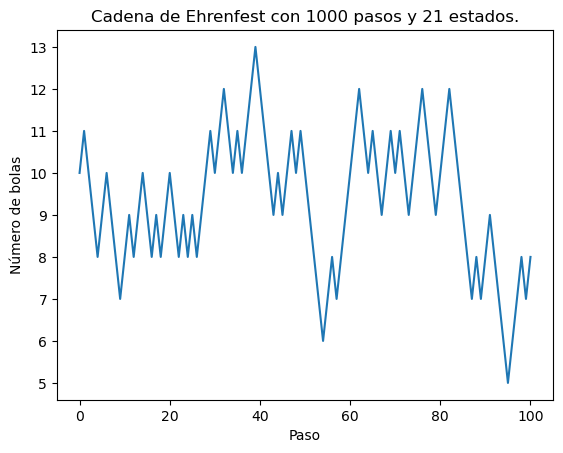

In [18]:
def exp(bolas):
    #Esta función recibe un número de bolas en la caja 1 y regresa el número de bolas después de dar un paso.
    dn = np.zeros((1,s+1)) #Crea un vector de 1 fila y s+1 columnas
    dn[0][bolas] = 1 #La probabilidad de que tengamos un número "bolas" de bolas es 1. (i.e., con seguridad tenemos esa cantidad)
    dtrans = dn@M #Transicionamos la matriz
    numbo = list(np.random.uniform(0,1)<np.cumsum(dtrans)).index(True) #De la nueva matriz obtenemos un nuevo número de bolas
    return numbo #regresa el número de pelotas nuevo


def sim_ehren(di, pasos):
    #Esta función toma la distribución inicial y número de pasos y regresa una realización de la cadena
    r0 = list(np.random.uniform(0,1)<np.cumsum(d0)).index(True) #Obtención del punto de partida
    ruta = [r0] #Lo guardamos en una lista donde iremos agregando cada uno de los pasos.
    for i in range(pasos): #Para cada paso 
        ruta.append(exp(ruta[-1])) #Realizamos el experimento con la función anterior
    return ruta
    
#Realizamos el experimento    
ruta = sim_ehren(d0,100) #El número de pasos es modificable

#Graficamos el resultado
plt.plot(ruta)
plt.xlabel("Paso")
plt.ylabel("Número de bolas")
plt.title("Cadena de Ehrenfest con %s pasos y %d estados." %(1000, s+1))
plt.show()

### Animación
En el siguiente bloque de código mostramos una animación del proceso. Esto es opcional y únicamente para propósitos de visualización.

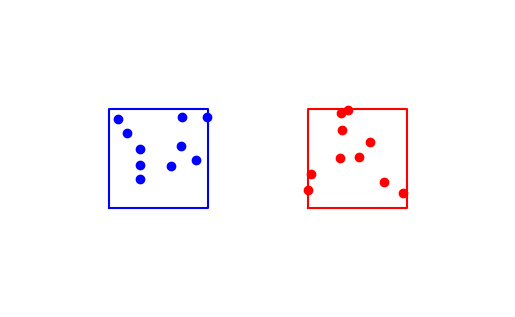

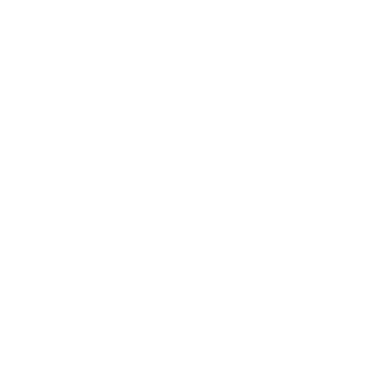

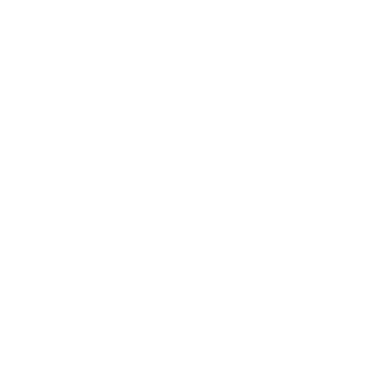

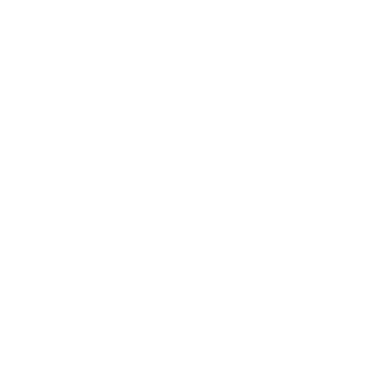

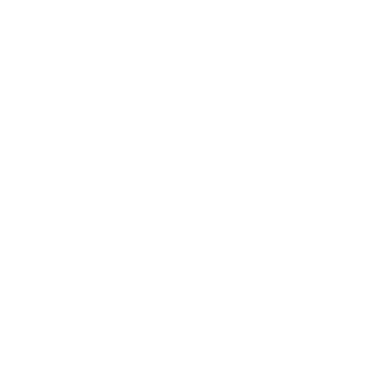

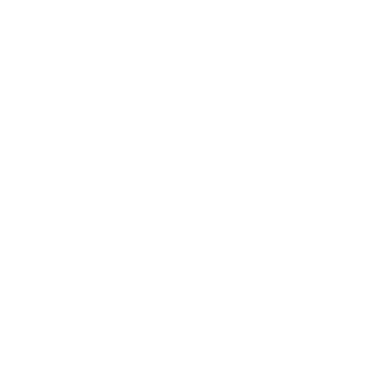

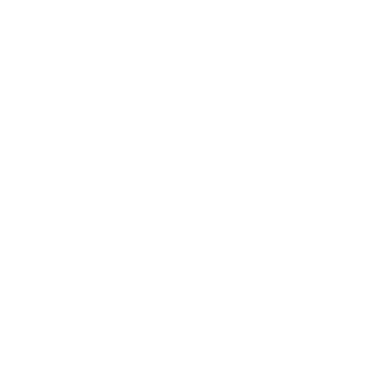

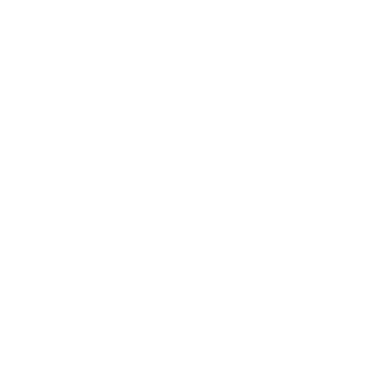

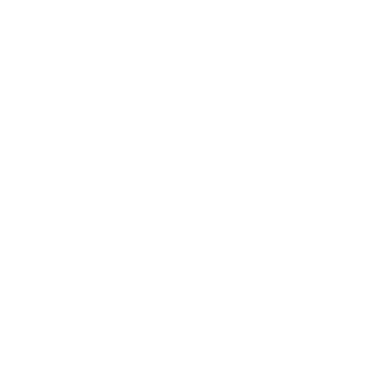

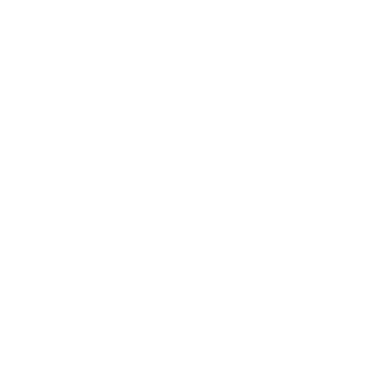

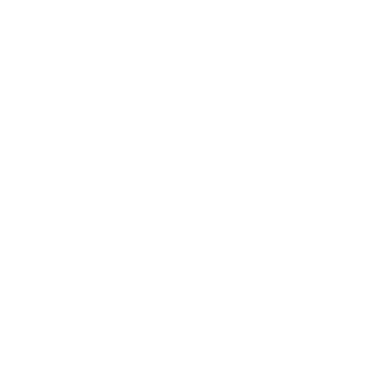

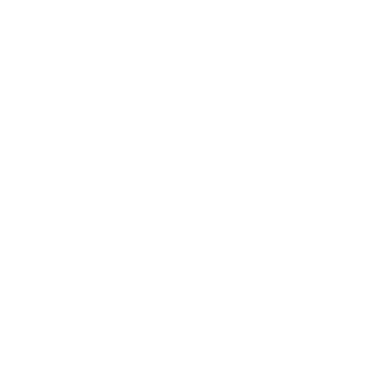

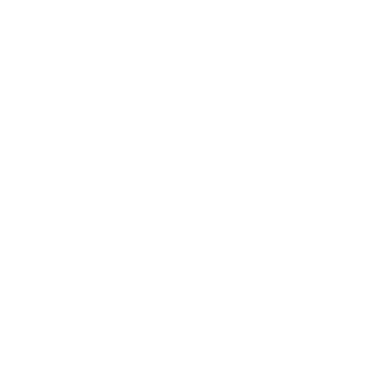

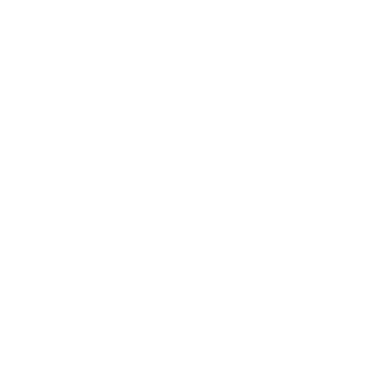

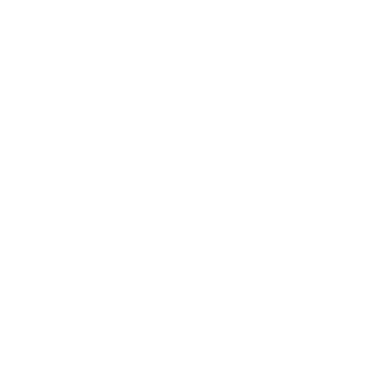

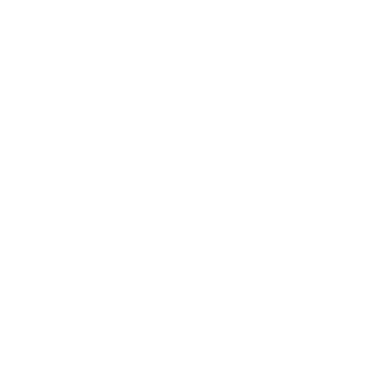

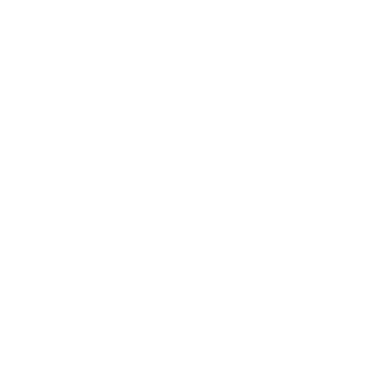

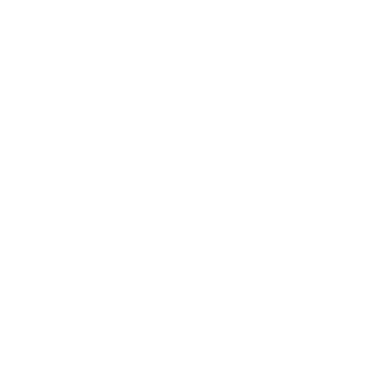

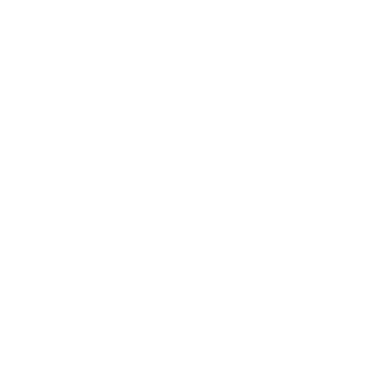

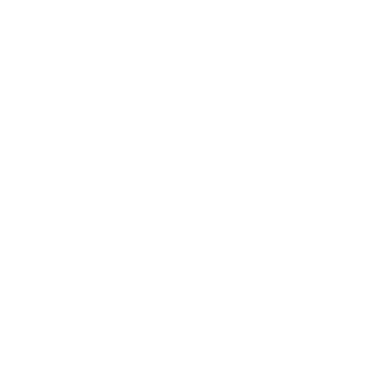

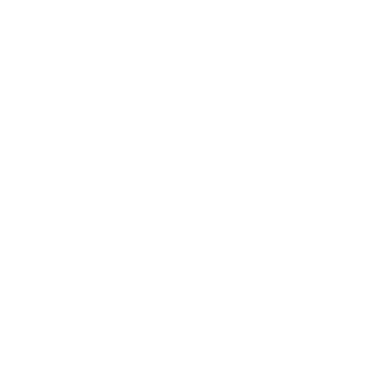

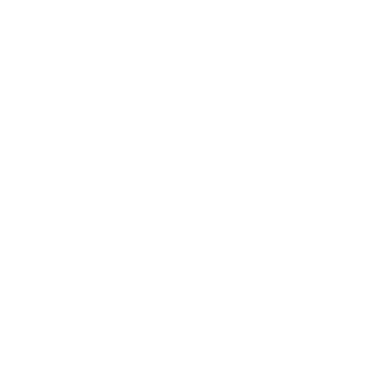

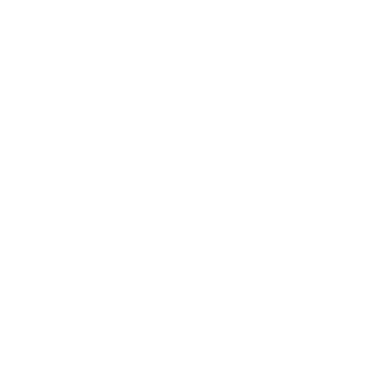

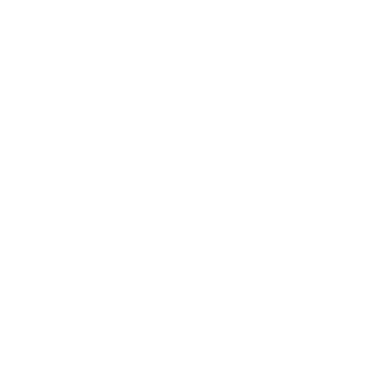

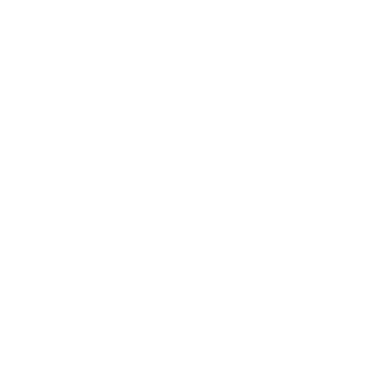

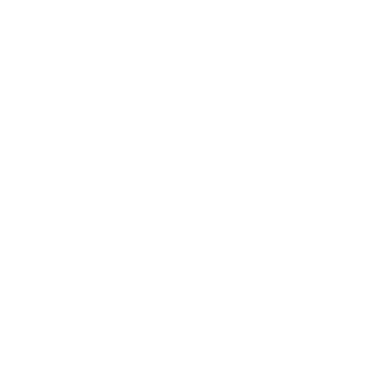

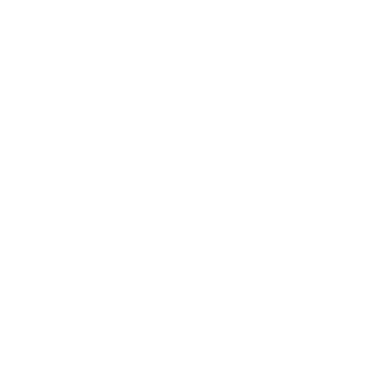

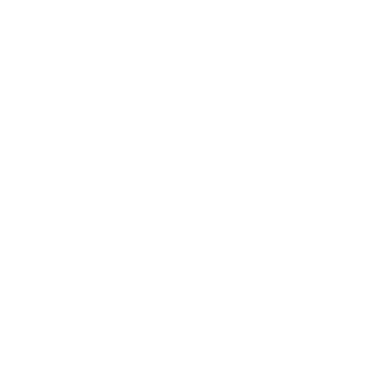

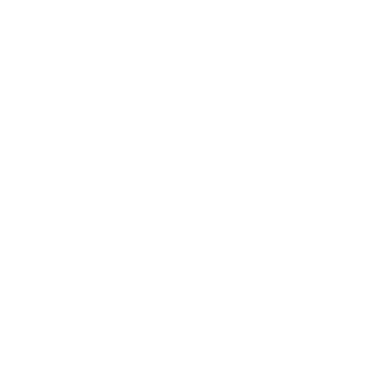

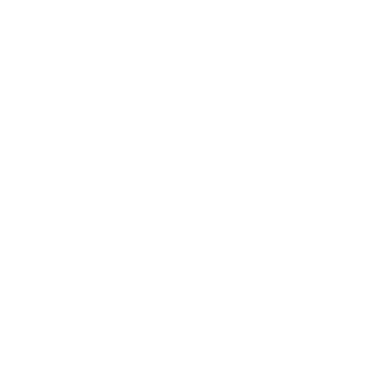

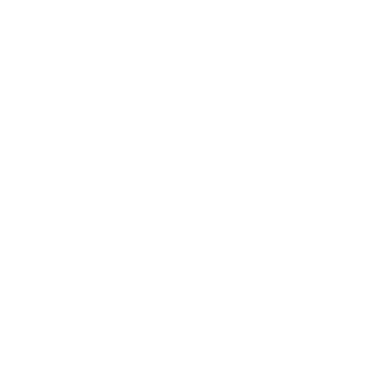

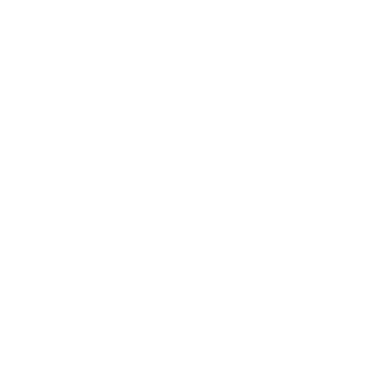

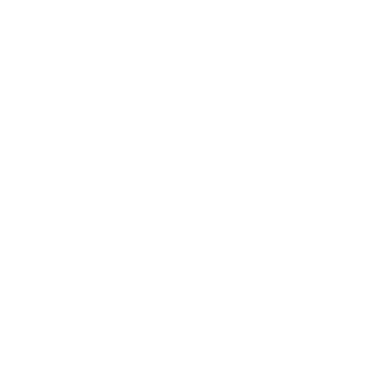

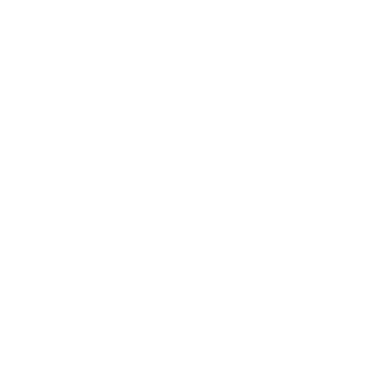

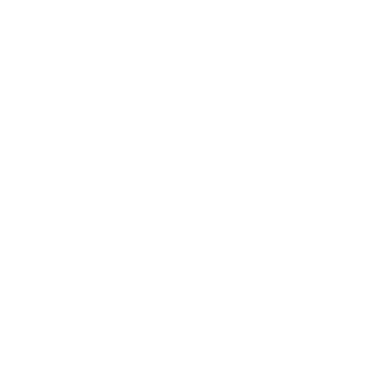

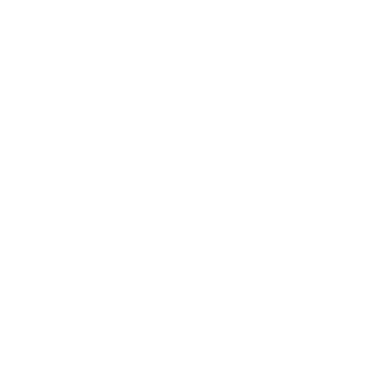

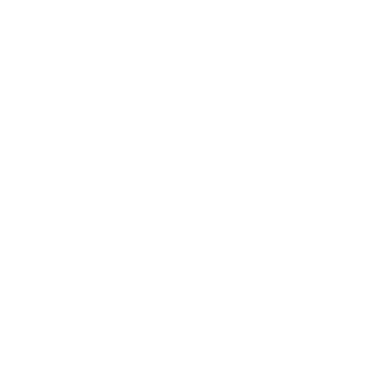

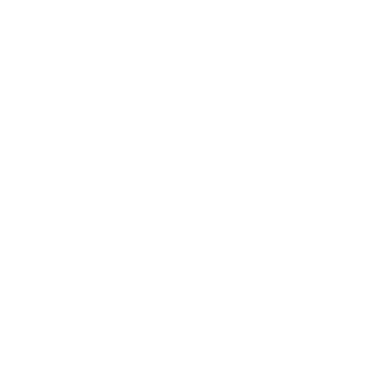

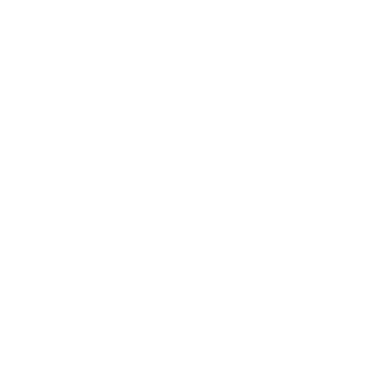

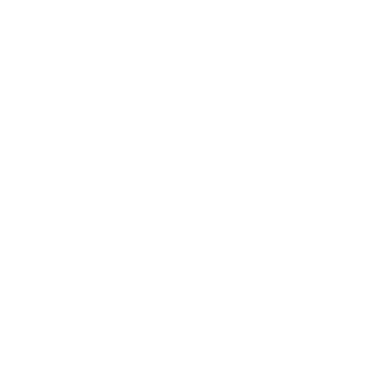

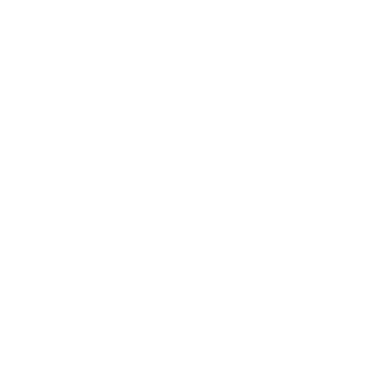

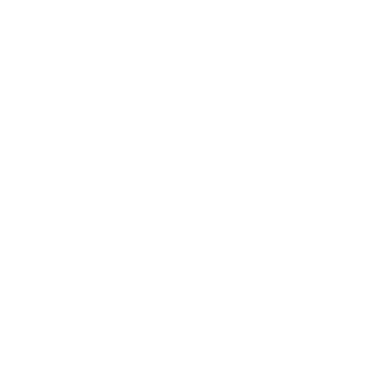

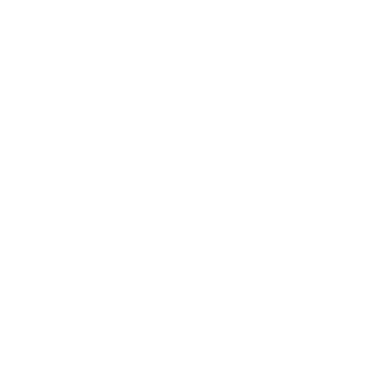

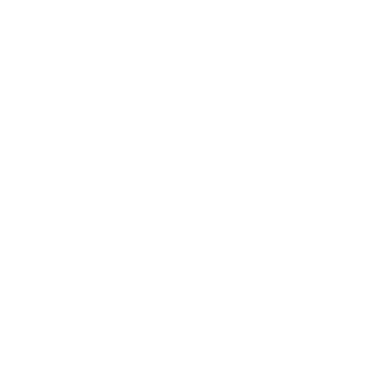

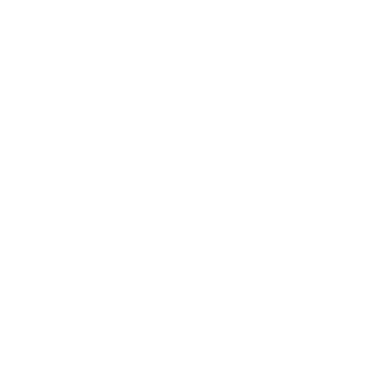

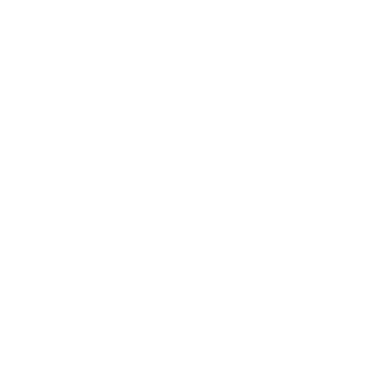

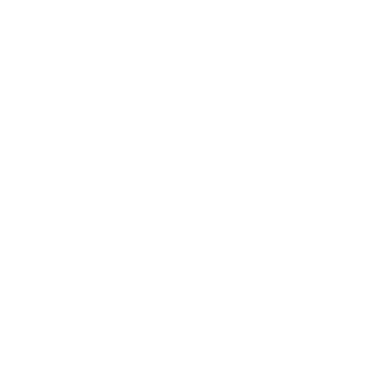

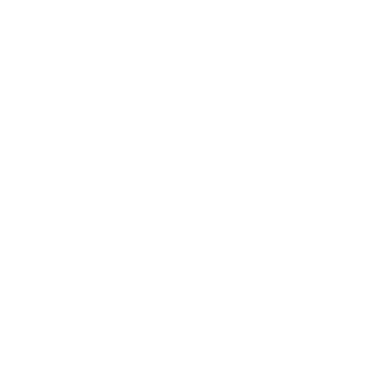

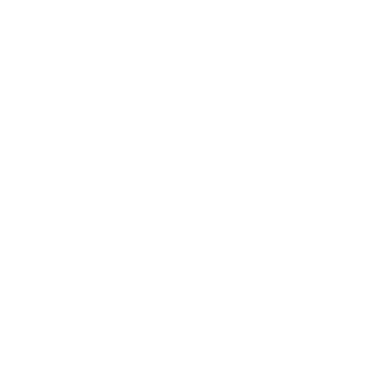

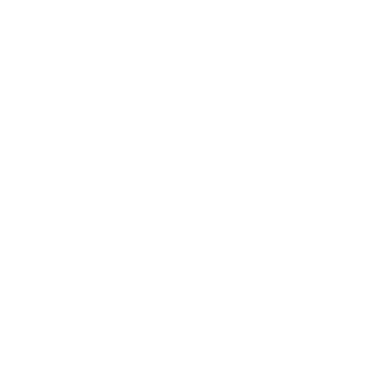

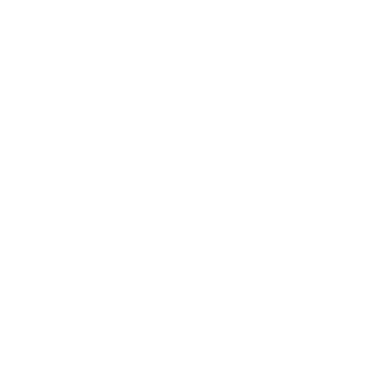

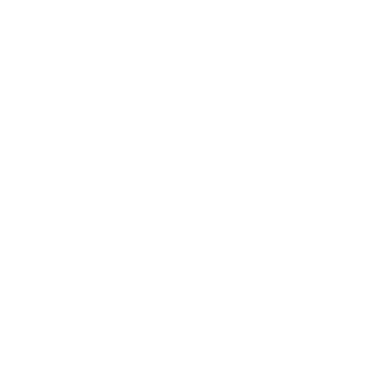

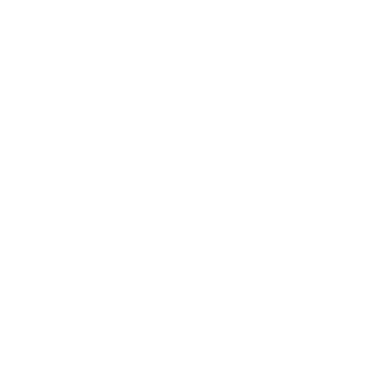

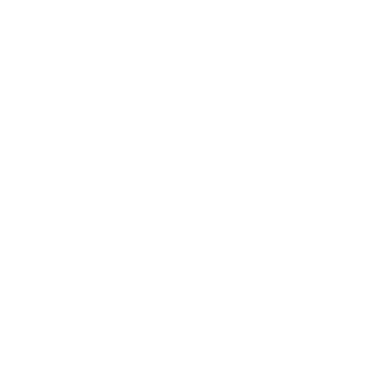

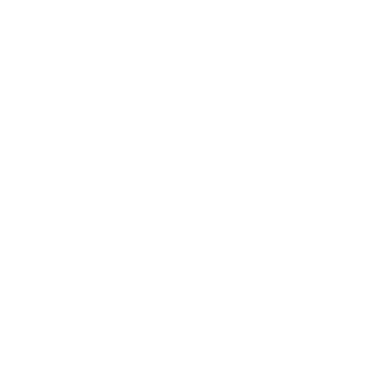

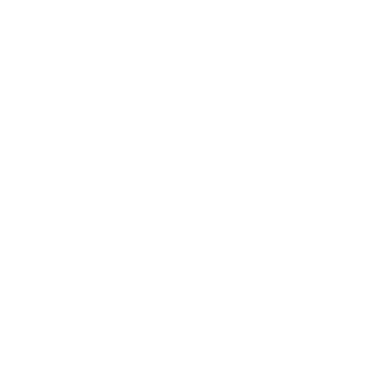

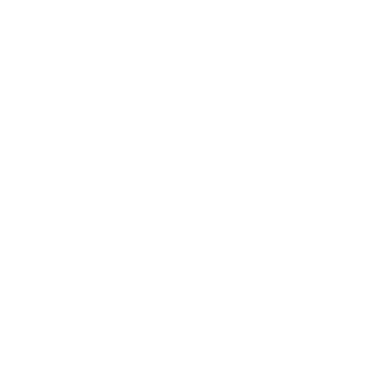

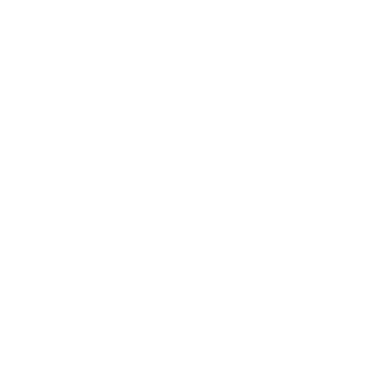

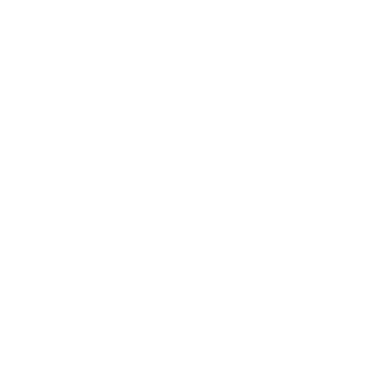

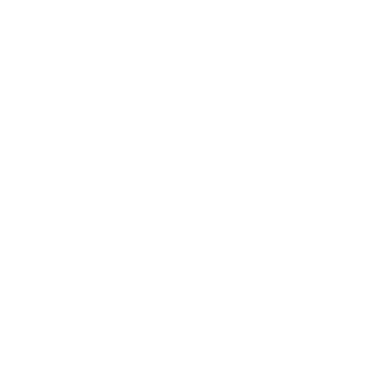

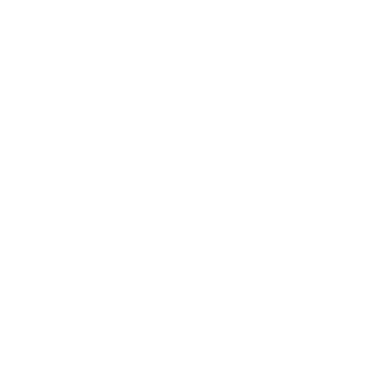

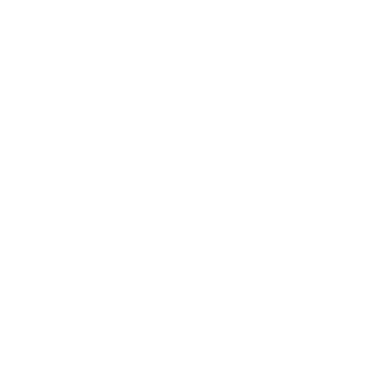

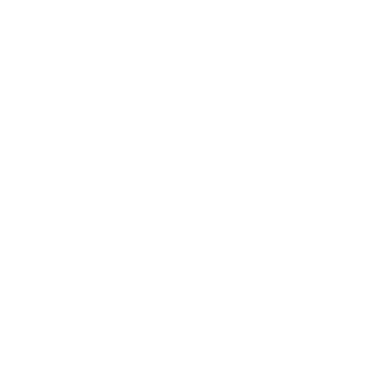

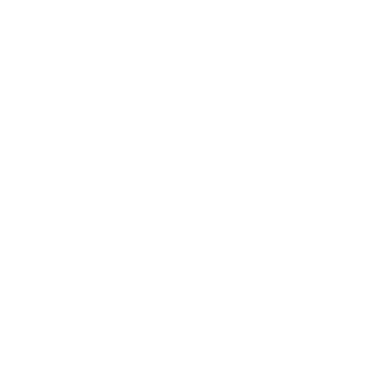

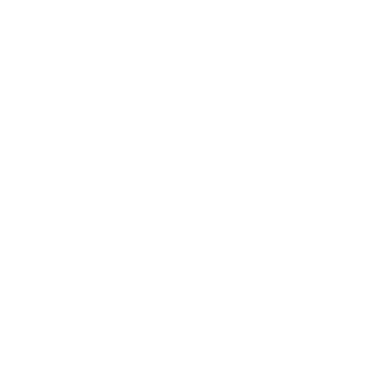

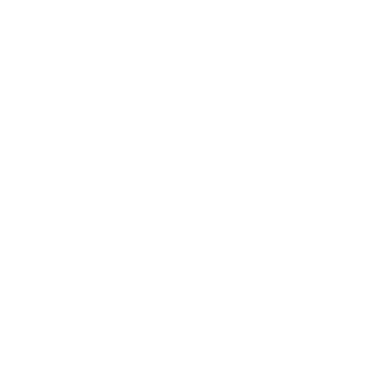

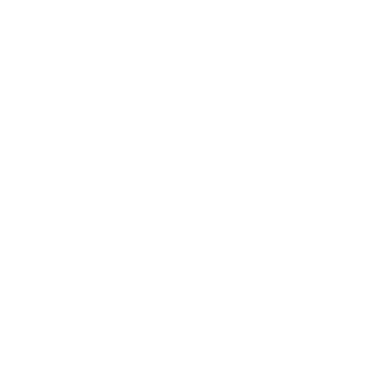

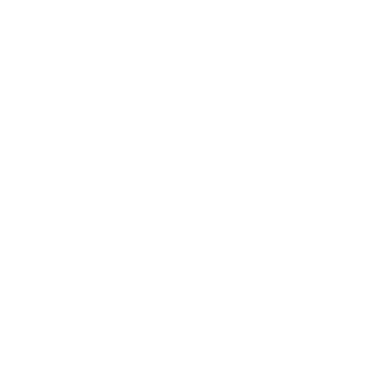

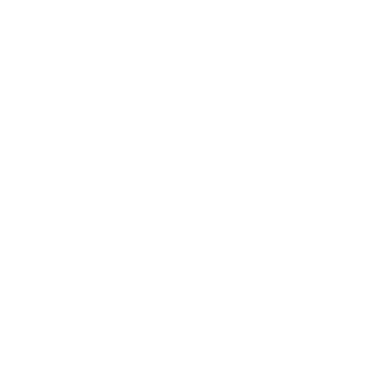

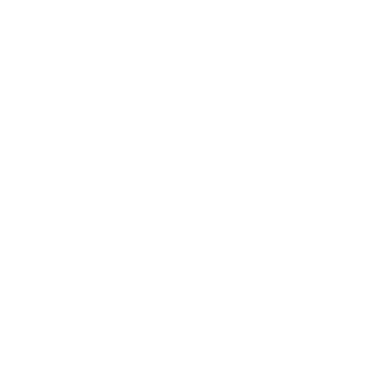

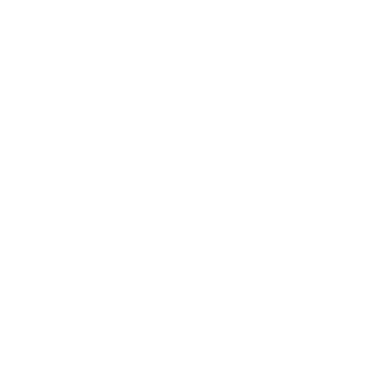

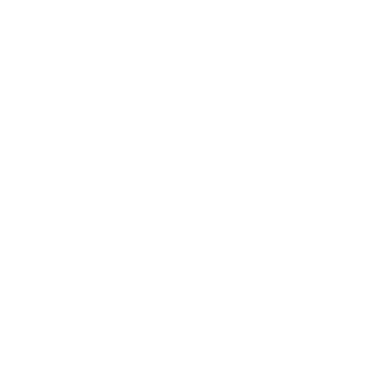

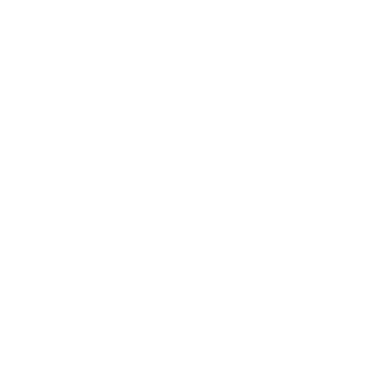

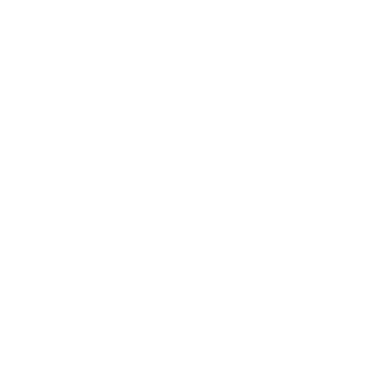

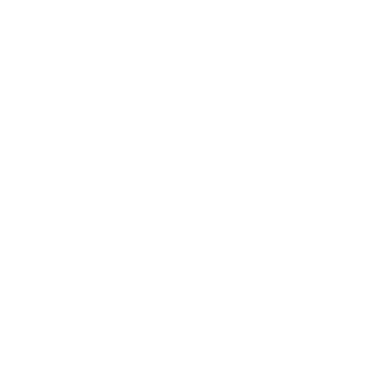

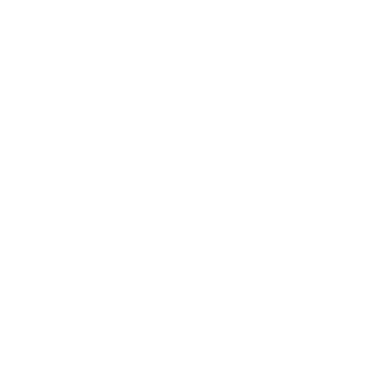

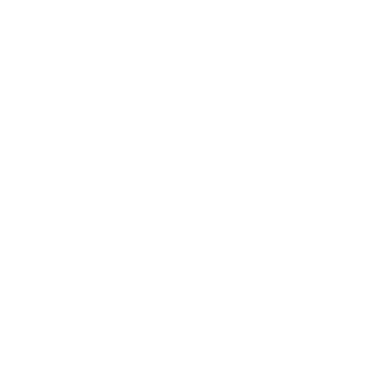

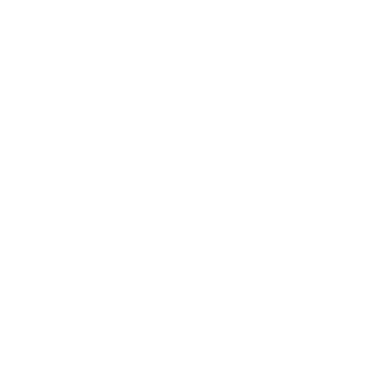

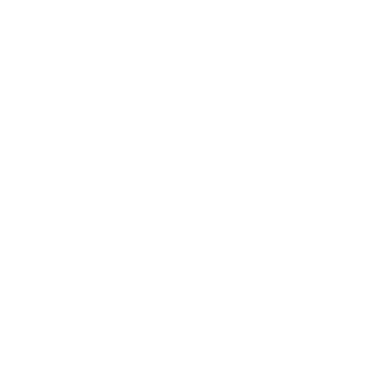

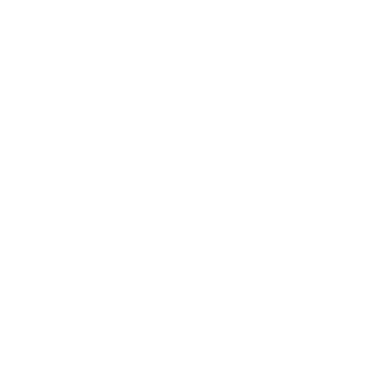

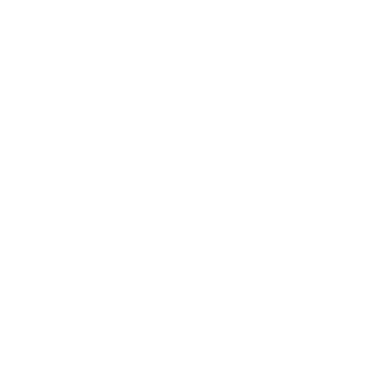

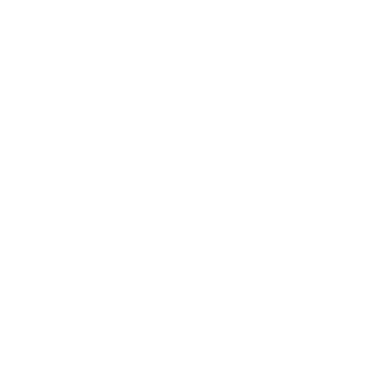

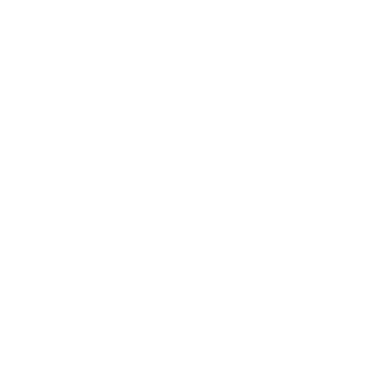

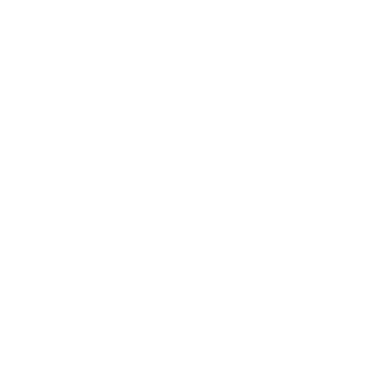

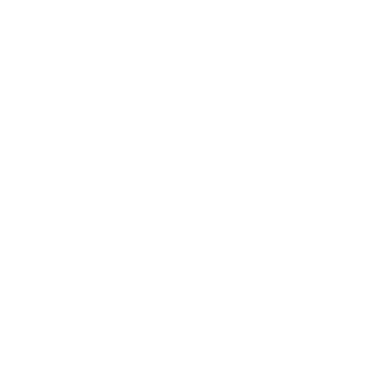

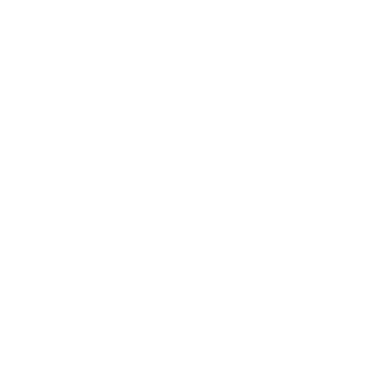

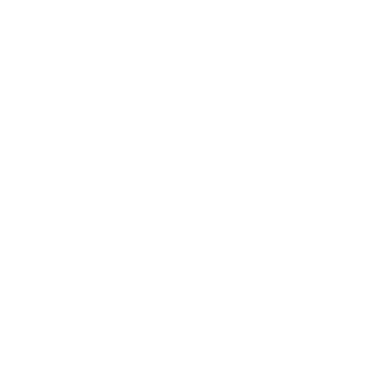

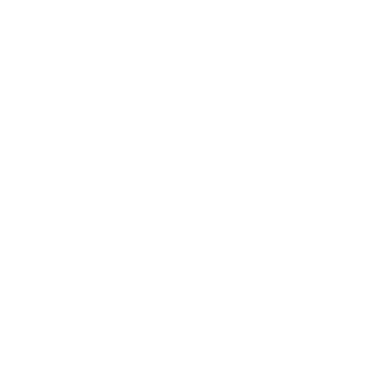

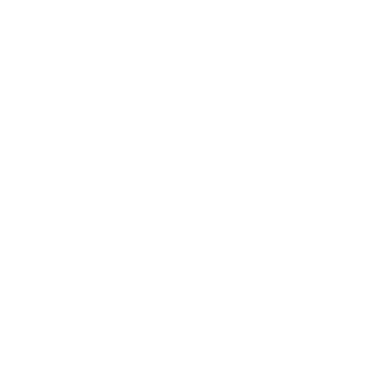

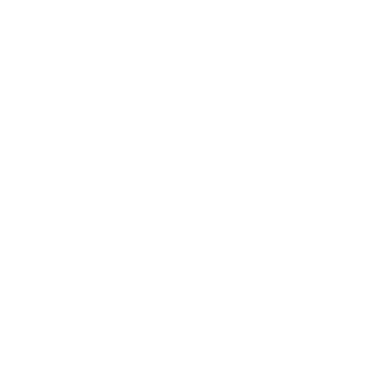

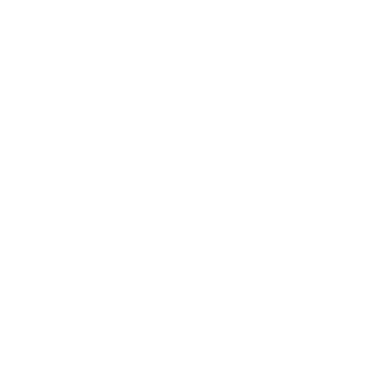

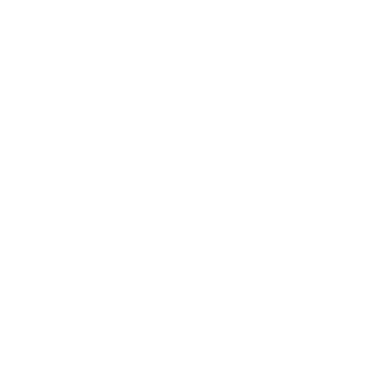

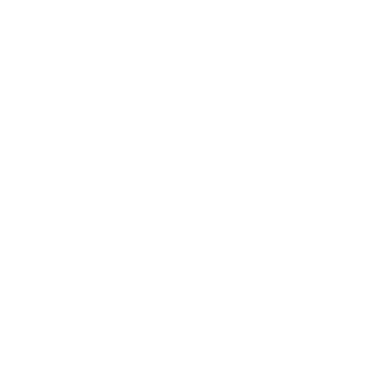

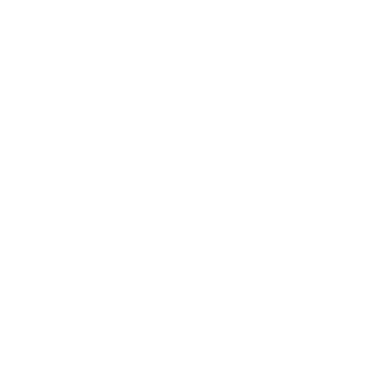

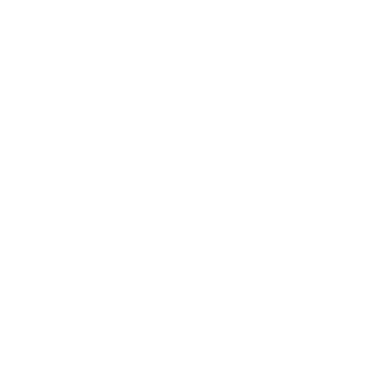

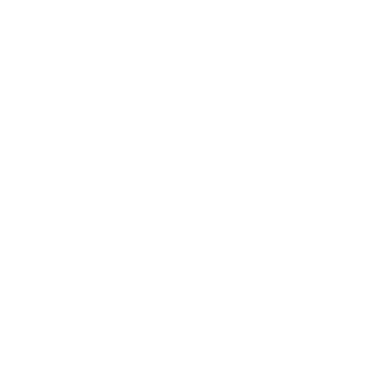

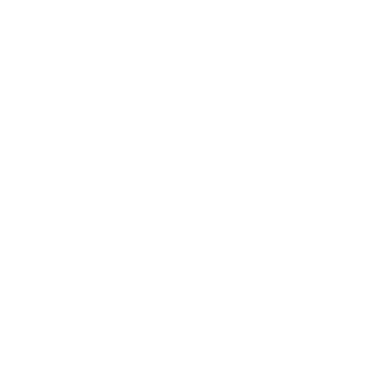

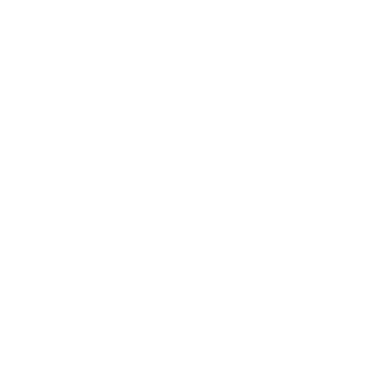

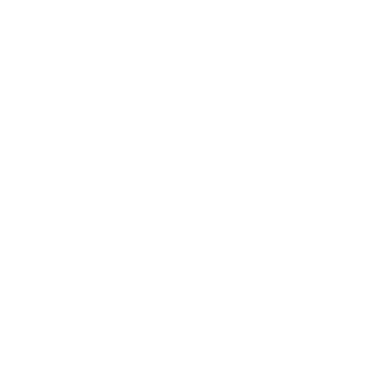

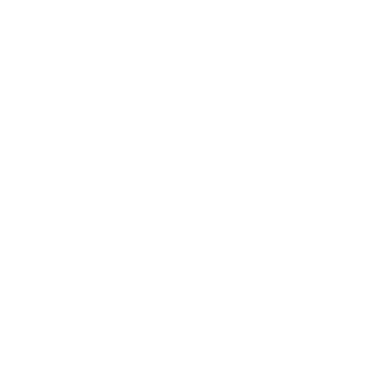

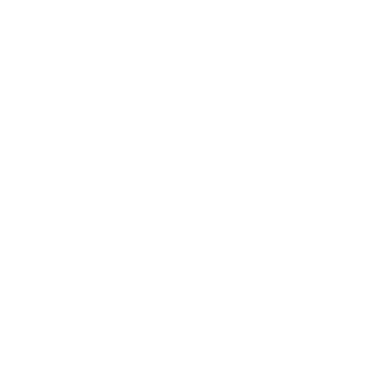

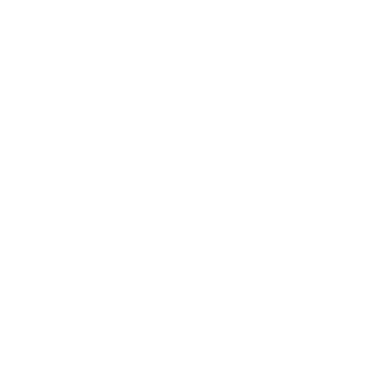

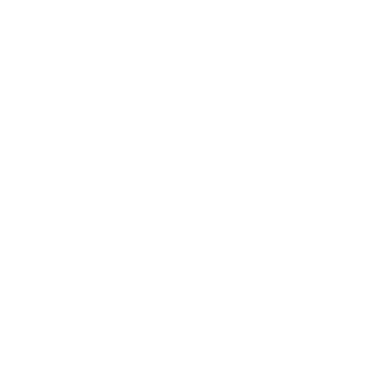

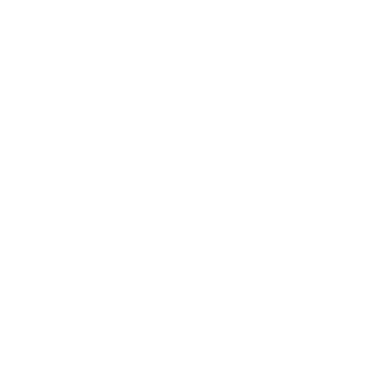

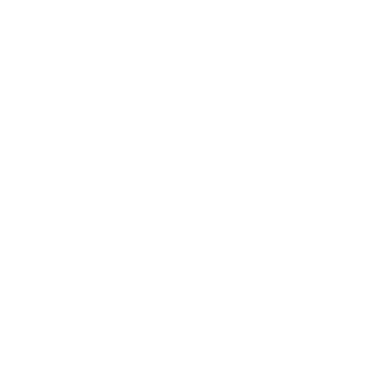

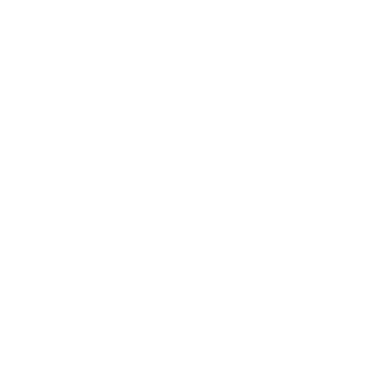

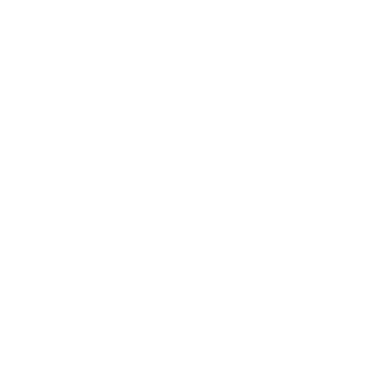

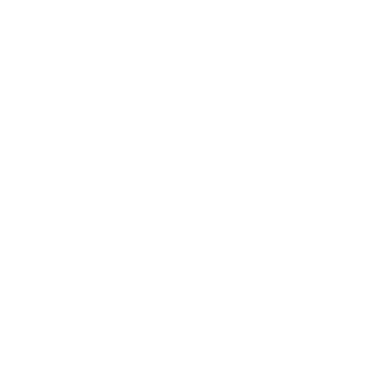

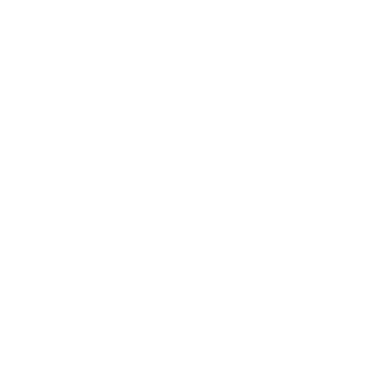

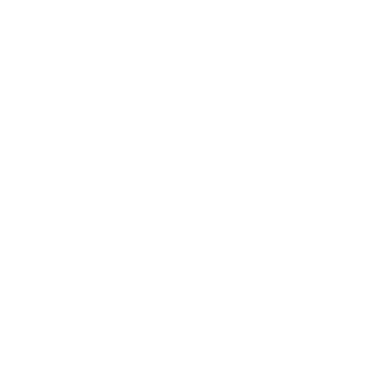

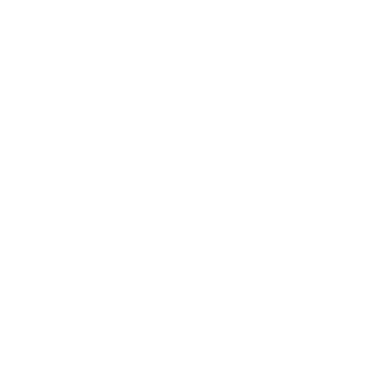

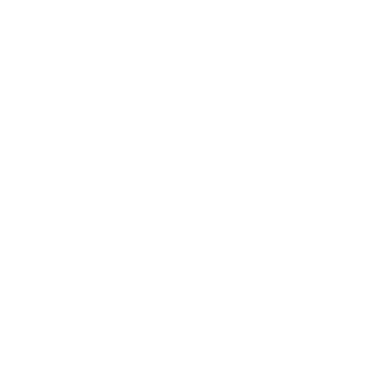

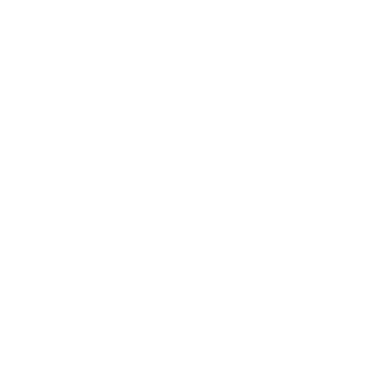

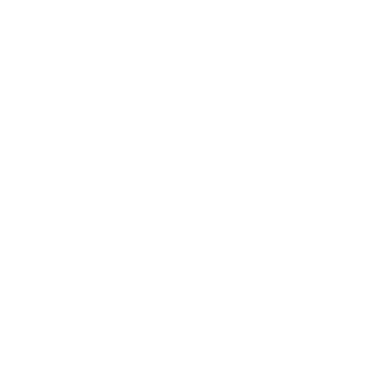

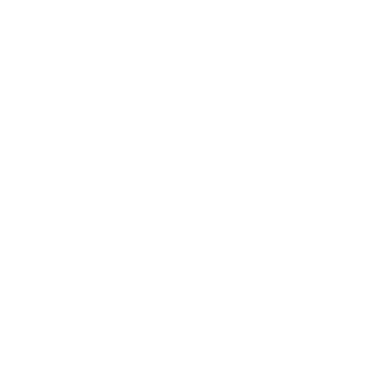

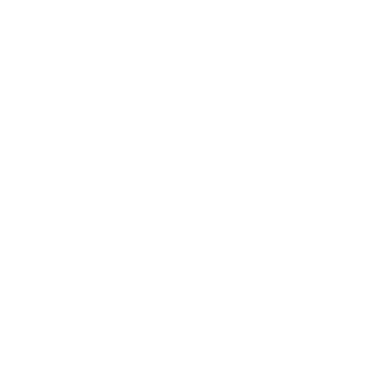

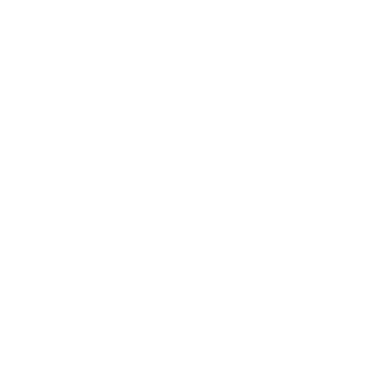

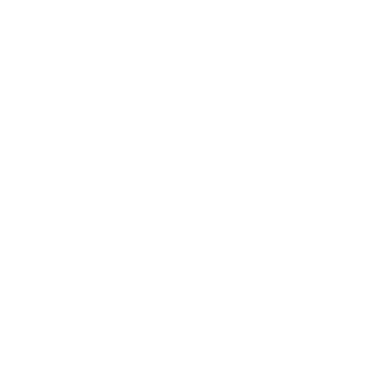

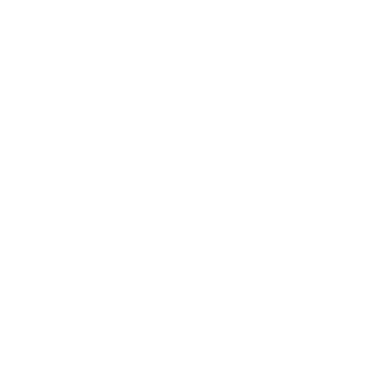

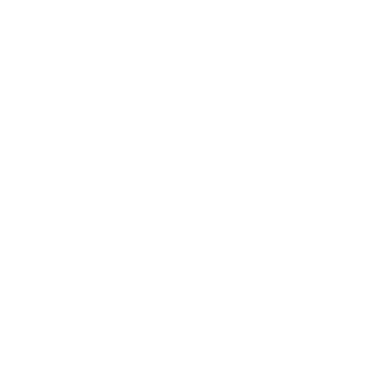

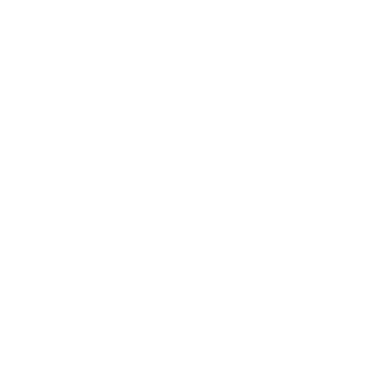

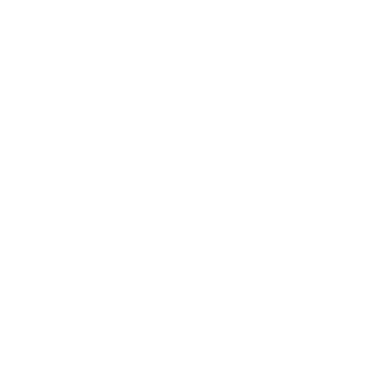

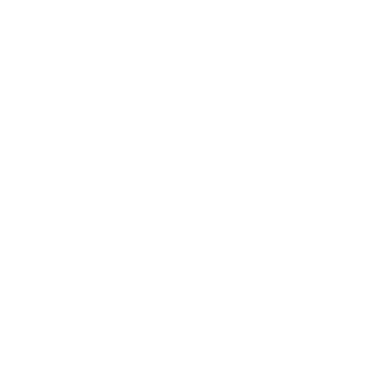

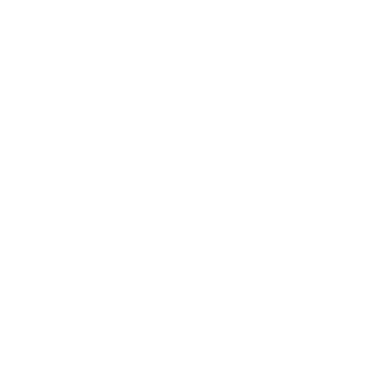

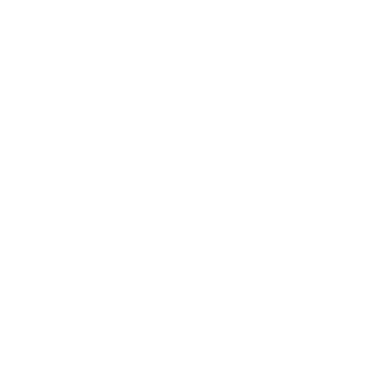

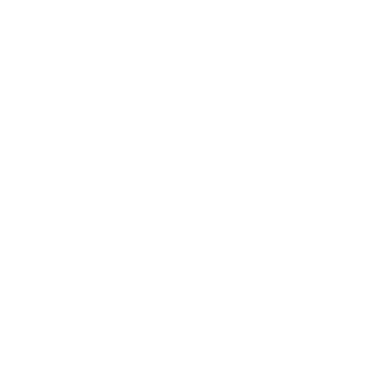

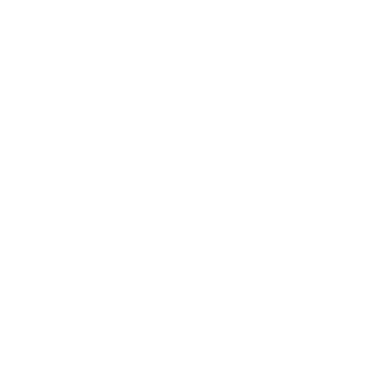

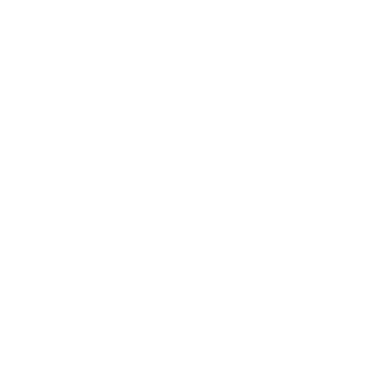

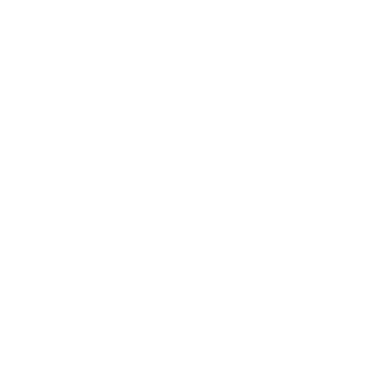

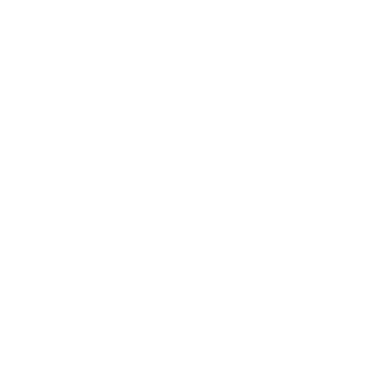

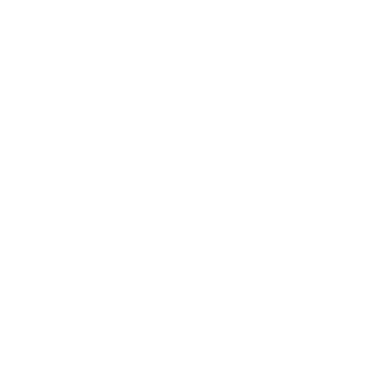

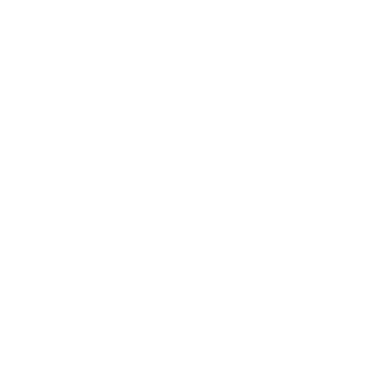

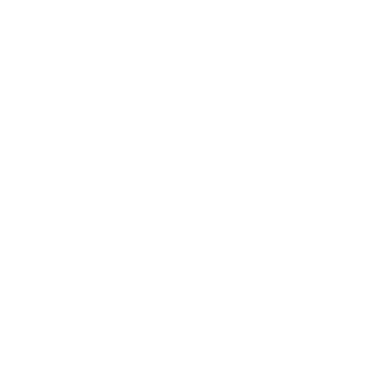

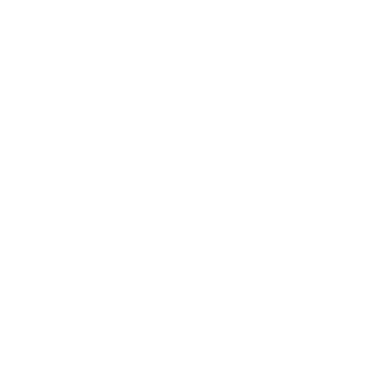

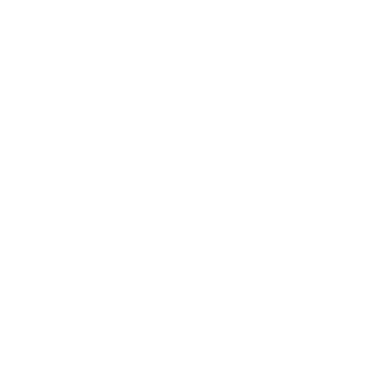

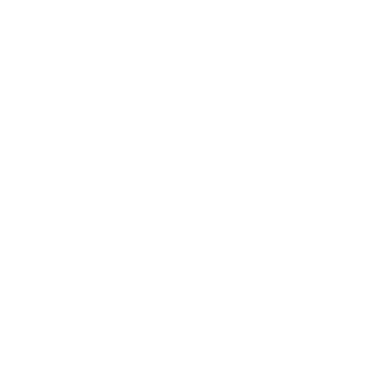

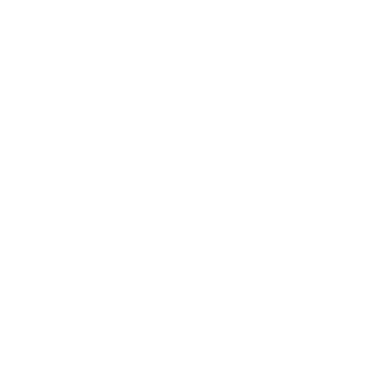

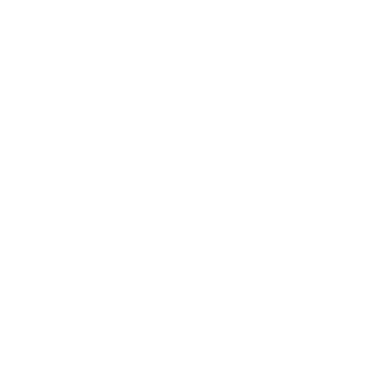

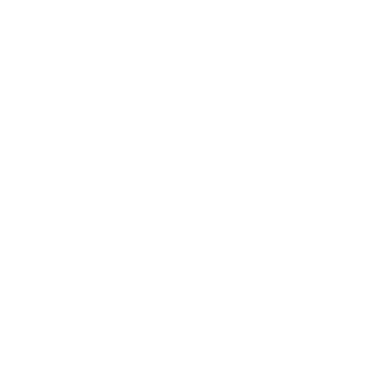

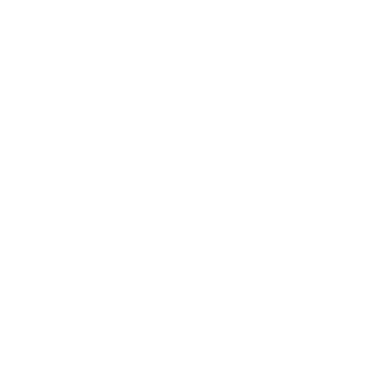

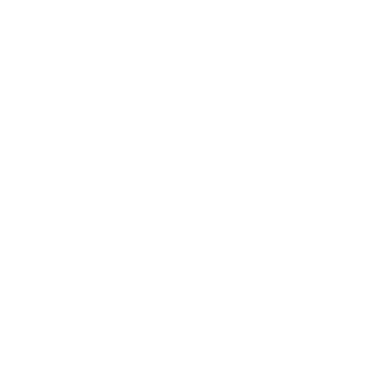

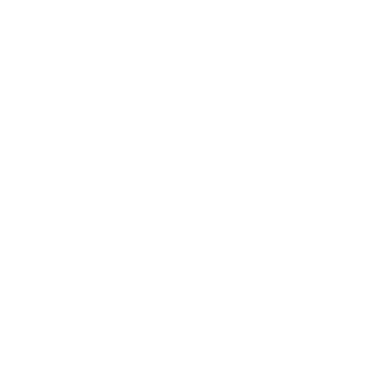

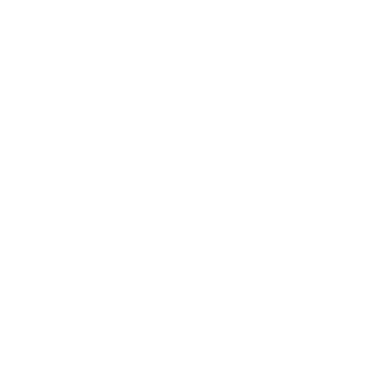

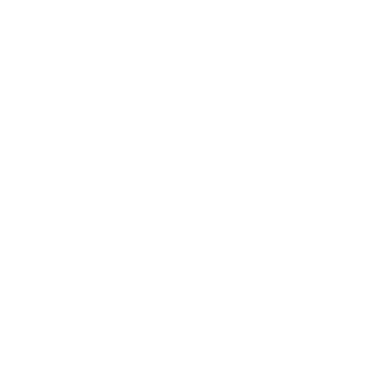

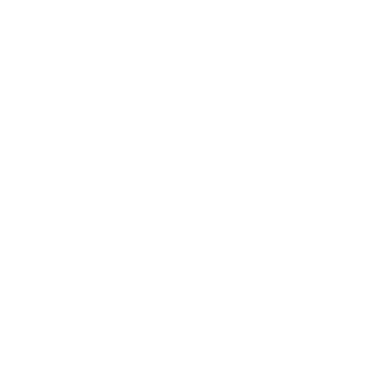

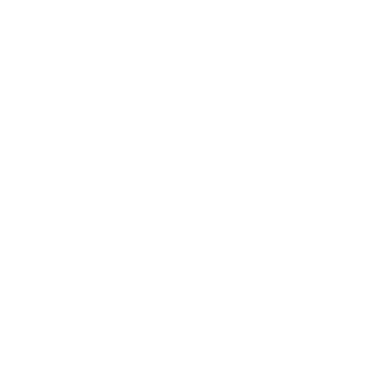

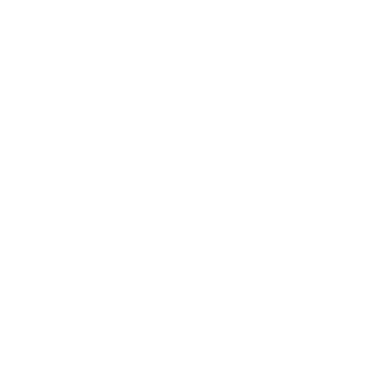

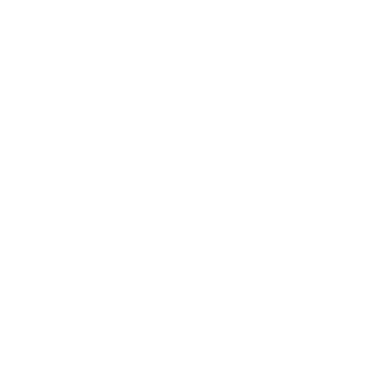

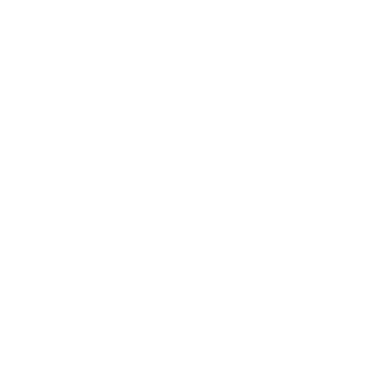

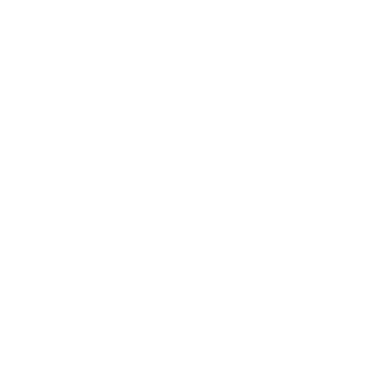

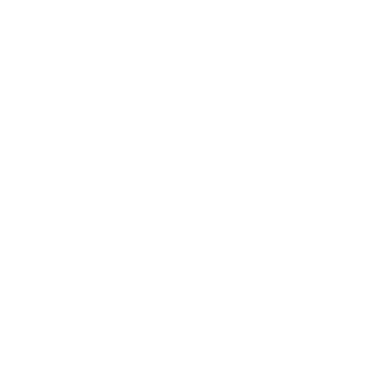

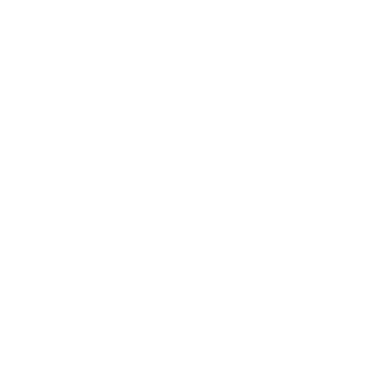

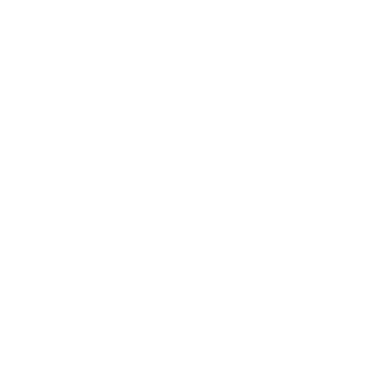

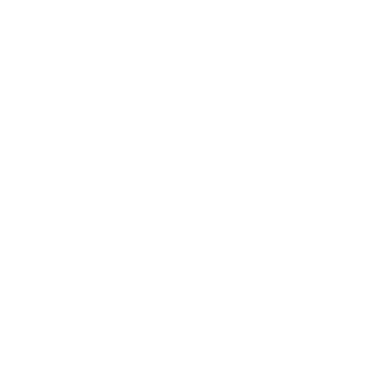

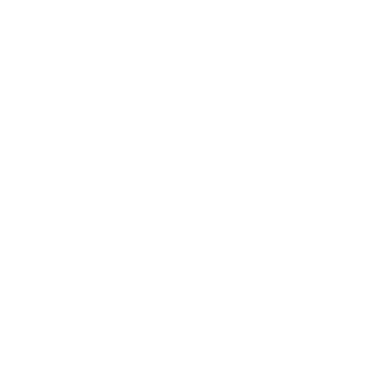

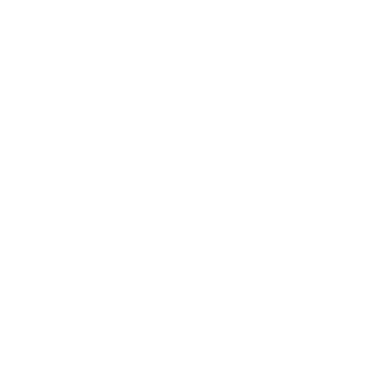

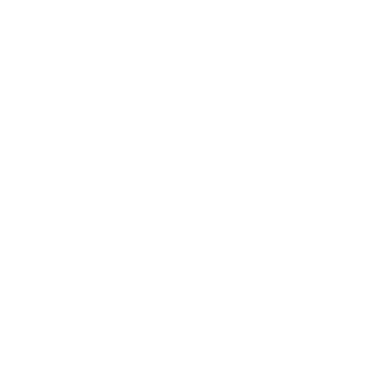

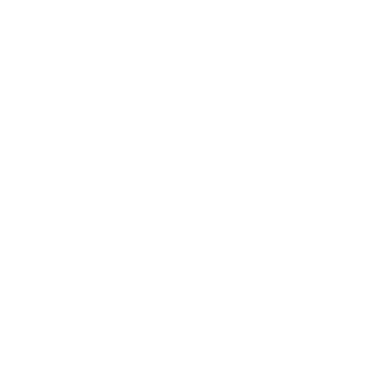

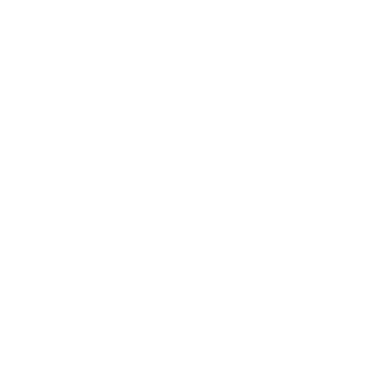

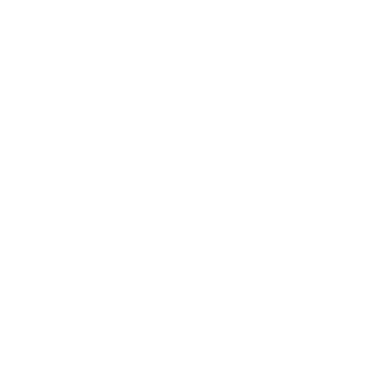

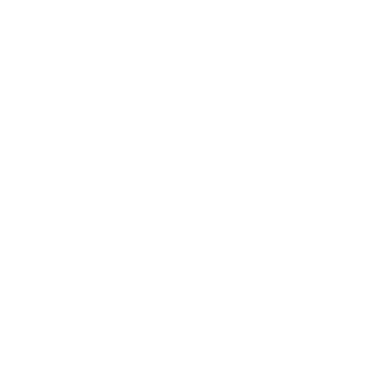

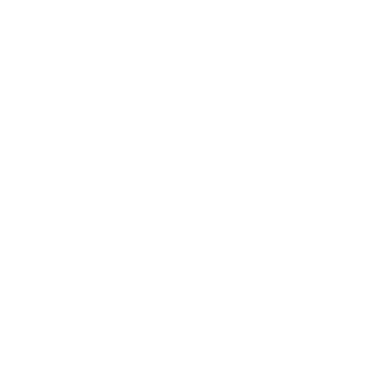

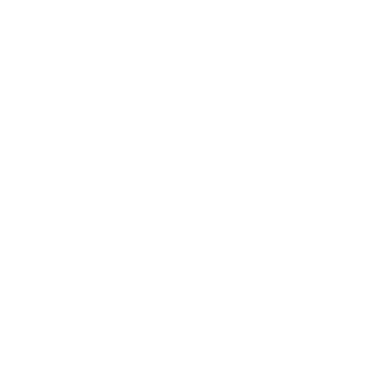

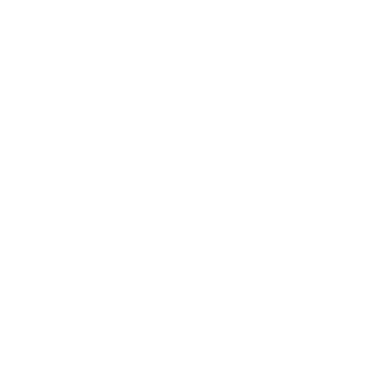

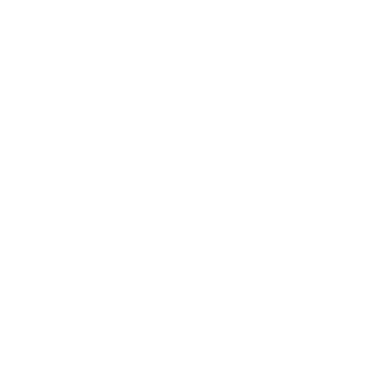

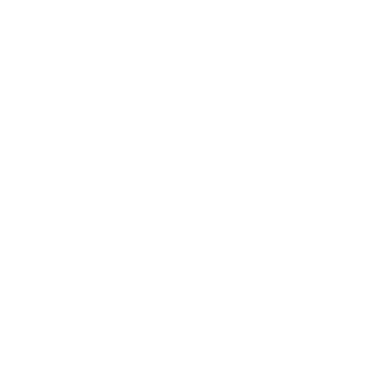

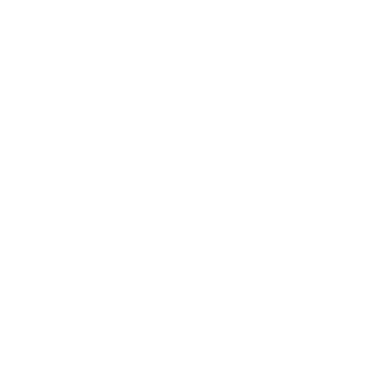

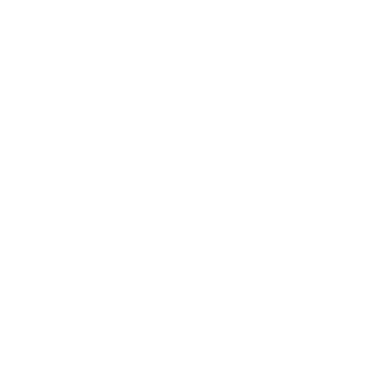

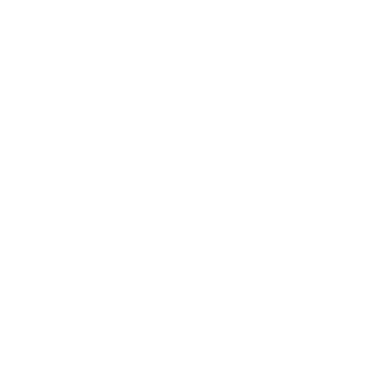

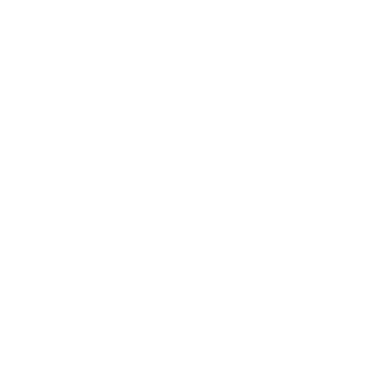

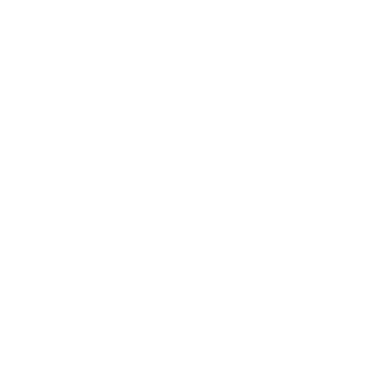

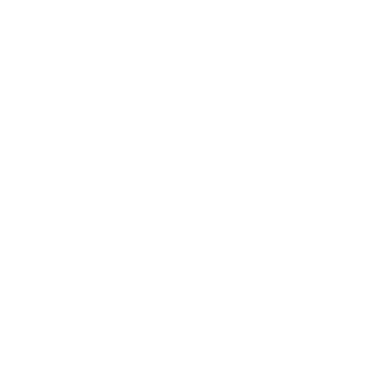

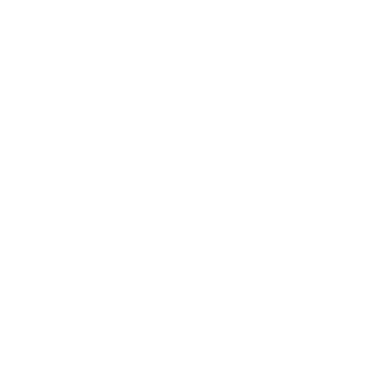

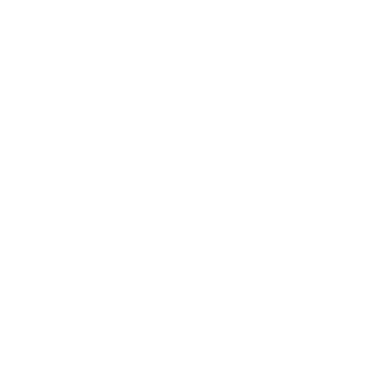

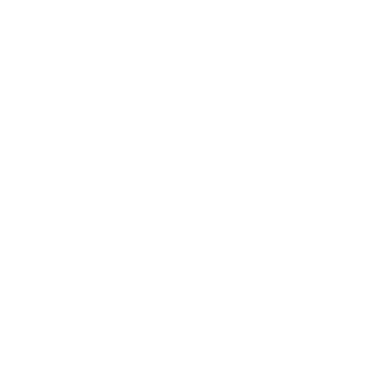

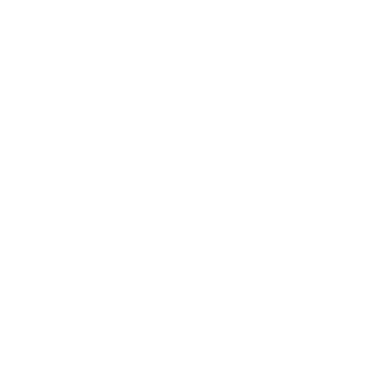

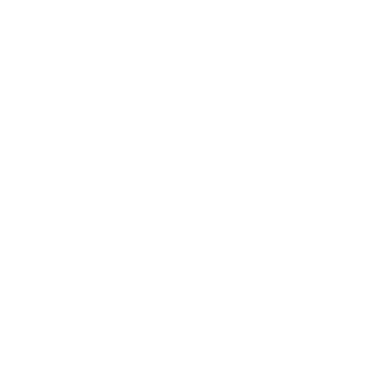

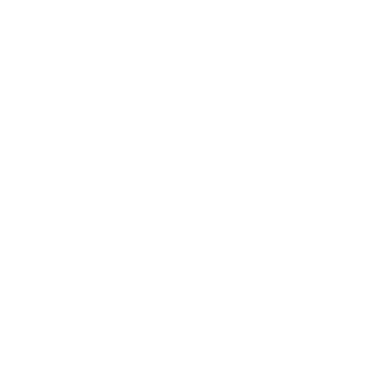

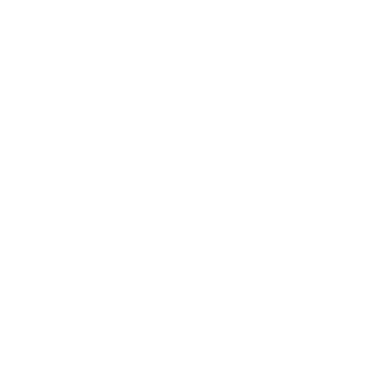

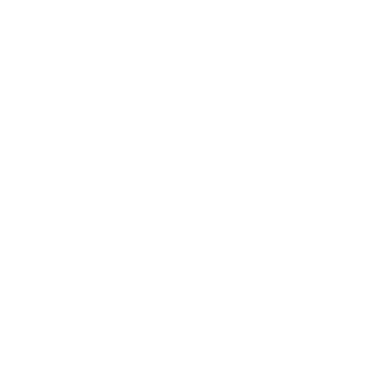

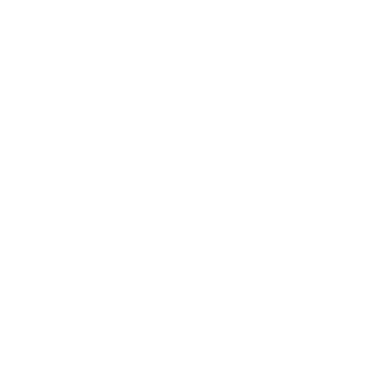

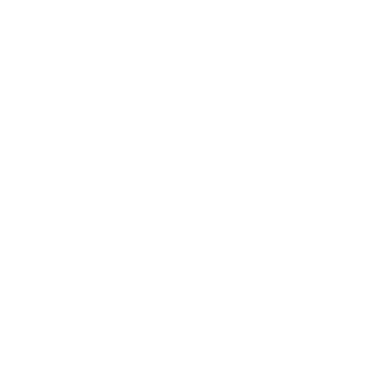

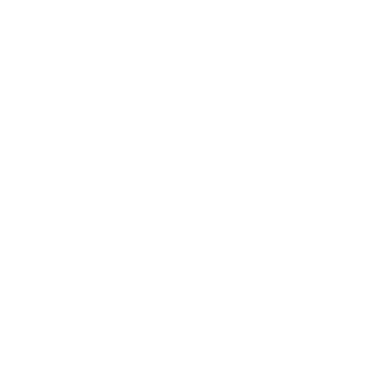

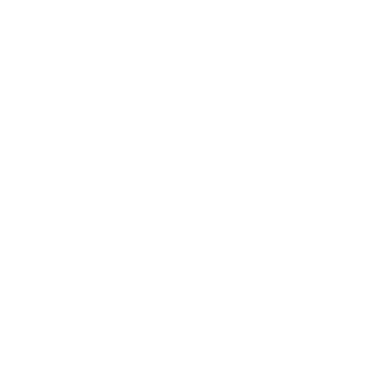

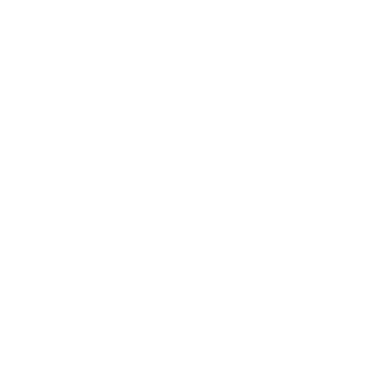

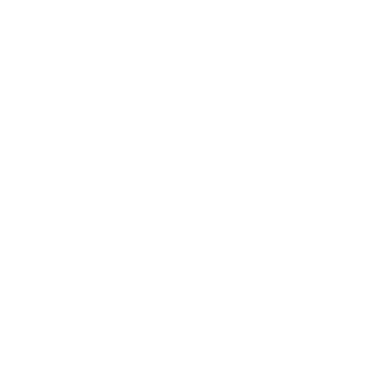

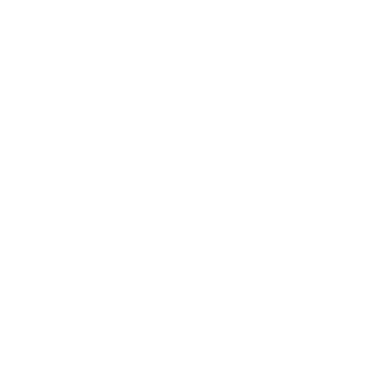

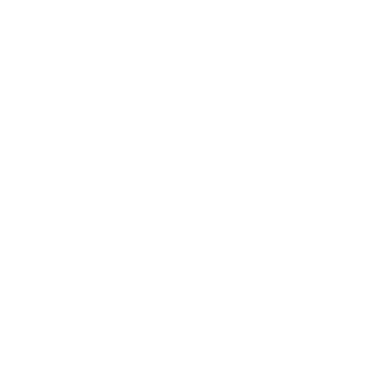

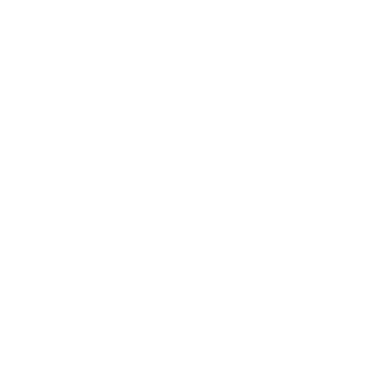

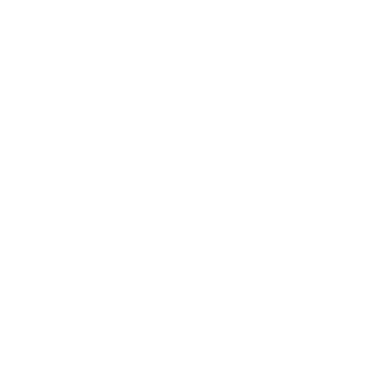

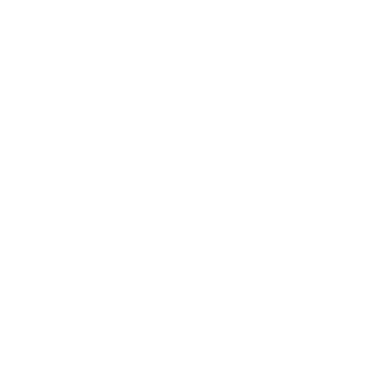

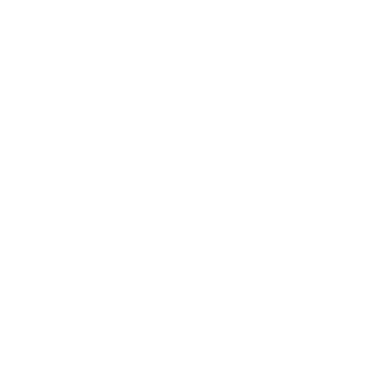

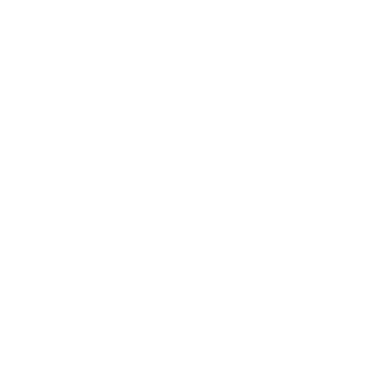

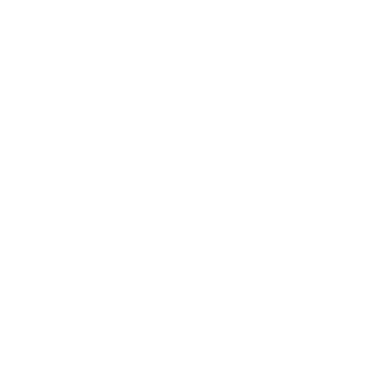

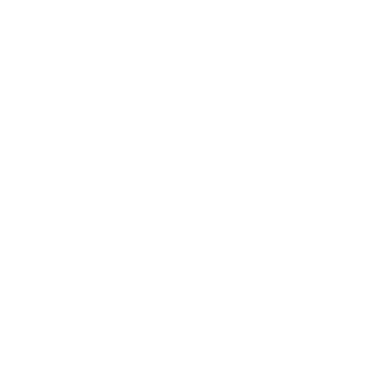

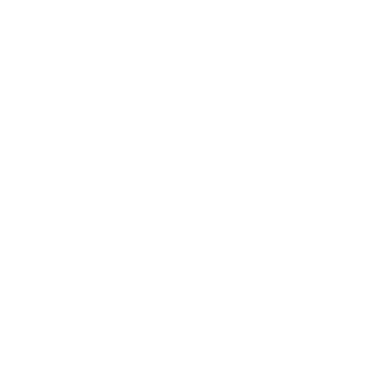

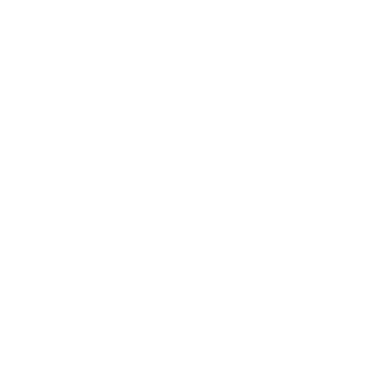

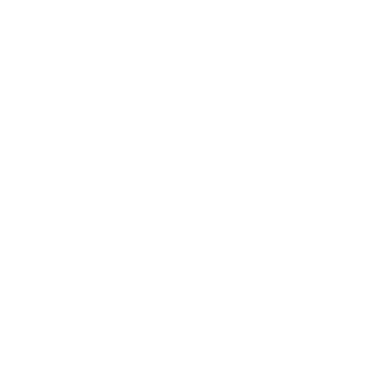

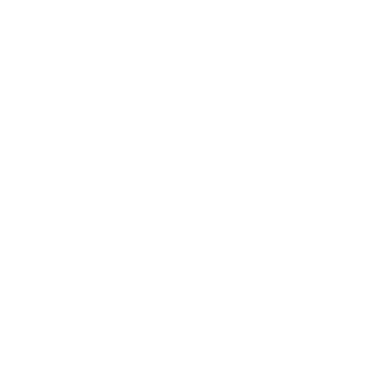

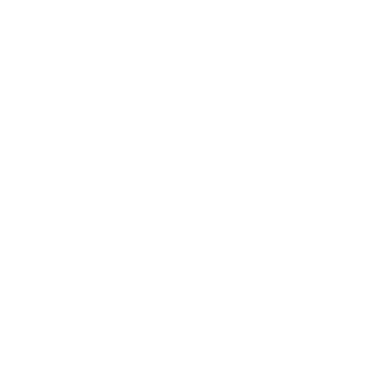

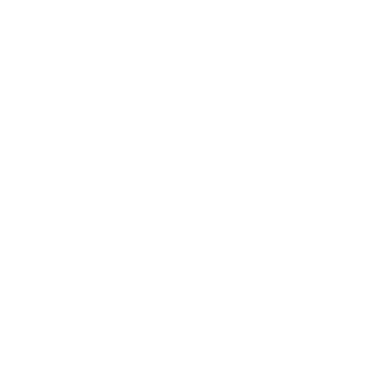

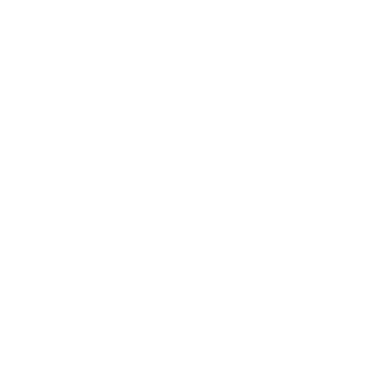

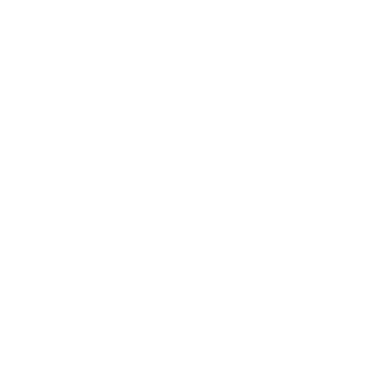

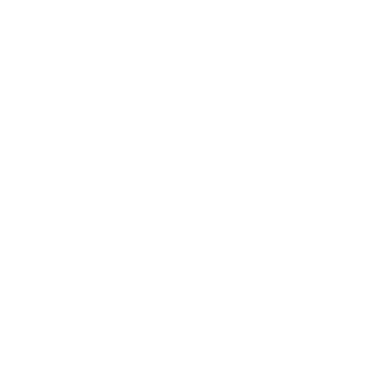

In [19]:
#Damos el entorno donde animaremos
fig, ax = plt.subplots()


def animate(i):
    ax.clear() #Limpiamos la gráfica pasada    
    
    #Dibujamos los cuadrados
    square1_corners = np.array([[0, 0], [0, 1], [1, 1], [1, 0], [0, 0]])
    square2_corners = np.array([[2, 0], [2, 1], [3, 1], [3, 0], [2, 0]])
    ax.plot(square1_corners[:, 0], square1_corners[:, 1], 'b-')
    ax.plot(square2_corners[:, 0], square2_corners[:, 1], 'r-')
    
    

    #Consideramos el ńumero de puntos en cada caja
    num_points_square1 = ruta[i]
    num_points_square2 = s-ruta[i]

    #Ponemos los puntos de la caja 1 en posiciones indistintas
    for _ in range(num_points_square1):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        ax.plot(x, y, 'bo')

    #Ponemos los puntos de la caja 2 en posiciones indistintas
    for _ in range(num_points_square2):
        x = random.uniform(2, 3)
        y = random.uniform(0, 1)
        ax.plot(x, y, 'ro')

    # Configuramos el tamaño de las cajas
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 2)


    # Mostramos
    plt.grid(False)
    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    
anim = FuncAnimation(fig, animate, frames=len(ruta), repeat=False)
anim.save('ehren.mp4', writer='ffmpeg')  # Save as an mp4 video
from IPython.display import HTML
HTML(anim.to_jshtml())

## 2. Estimación e interpretación de resultados. 

Ya que tenemos una forma de simular nuestra cadena, programaremos algunos bloques de código que nos permitan hacer lo siguiente: 
- Determinación del tipo de estado (transitivo, recurrente o absorbente)
- Visualización del procedimiento
- Decir si dos estados pertenecen a la misma clase de comunicación
- Estimación del tiempo de llegada

(Esto será una calca prácticamente en cada uno de los ejemplos).



### Tipo de estado

Programaremos un código que nos diga de qué tipo es un estado. Para ello simularemos una cantidad finita de pasos y, con base en cierto umbral, decidiremos el tipo de estado del que se trata. Después repetiremos este procedimiento una cantidad finita de veces y, con base en los resultados, conjeturaremos el tipo de estado ante el que nos encontramos. La base teórica para esto es la siguiente: 

$$
G(x,y) = \mathbb{E}(N_{y})
$$

Si el estado es transitivo, entonces el número de veces que se pasa por él es finito, i.e., $G(x,y)<\infty$ y si es recurrente, $G(x,y) \to \infty$. Normalizaremos la esperanza del número de visitas. De esta forma podremos decir que, si tiende a $1$, tiene oportunidad de ser recurrente. Si tiende a $0$, tiene oportunidad de ser transitorio. 

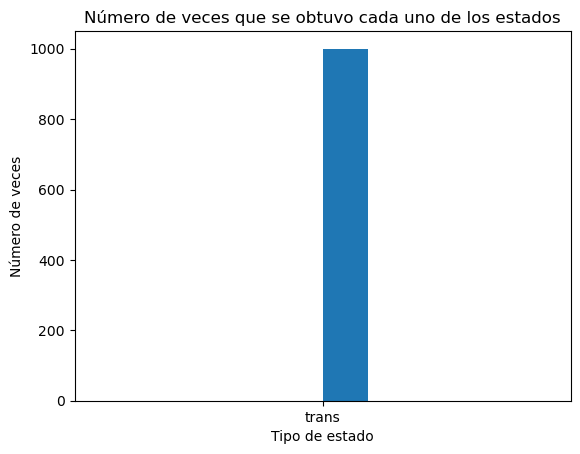

In [21]:
#Tipo de estado
#Construiremos una función que determine el tipo de estado.

def tipo(edo, di, npa = 100, ut = 0.1, ur = 0.1, ua = 0.1): 
    '''
    Esta función tiene los siguientes argumentos:
    edo: (entero entre 0 y s): el estado del cuál queremos averigüar el tipo
    di: la distribución inicial con la que se está trabajando. Se recomienda dar una donde, con P = 1 iniciemos en edo
    npa: el número de pasos que da la cadena. Por default son 1000.
    ut: umbral de estado transitorio. Si en el "límite" la función queda a esta distancia del cero, se presume transitorio
    ur: umbral de estado recurrente. Si el "límite" de la función queda a una distancia 1-ur del 1, se presume recurrente.
    ua: porcentaje de la cola de la cadena que consideraremos para afirmar que el estado es absorbente.
    '''
    simulacion = np.array(sim_ehren(di, npa)) #Simulamos la cadena con _npa_ pasos y la distribución inicial _di_. Guardamos en un array para operar.
    flags = simulacion == edo #La ruta obtenida al simular la cadena queda transformada en 0 y 1 donde 1 es un paso por el estado analizado.
    pasadas = np.cumsum(flags)/np.arange(1, npa + 2) #Se guarda en otro arreglo el número de visitas al estado dividido por el paso de la cadena. 
    
    #print(simulacion) Descomentar esta línea para ver cada una de las rutas
    
    if pasadas[-1] < ut: #Si en el límite (i.e., npa) la sucesión queda a una distancia ut del 0
        return 'trans', simulacion, pasadas #El estado se clasifica transitivo y se regresa una string con esto.
    
    elif pasadas[-1] > (1-ur): #Si en vez de eso quedamos a una distancia ur del 1
        ultimos_N=int(ua*npa) #Primero vemos el ua% de los pasos dados

        if flags[-ultimos_N:].sum()>(ultimos_N-1): #Si la cola de la sucesión sigue creciendo, es absorbente
            return 'absorbente',simulacion, pasadas #Clasificamos absorbente y regresamos la cadena y la sucesión
        
        else: #En otro caso resulta recurrente.
            return 'recurrente',simulacion, pasadas
    else: #Si no se pudo clasificar con lo anterior, lo nombramos indecidible y regresamos la 3-pla con una string
         return 'indecidible', simulacion, pasadas


#Simulamos varias veces para tener una _educated guess_ del tipo de estado.

def disc(edo, di, re = 1000):
    '''
    edo: el estado a analizar
    di: distribución inicial
    re: número de repeticiones del análisis
    '''
    props = [] #Crea lista donde guardaremos el tipo de estado obtenido según simulación.
    for i in range(0,re): #Loop de _re_ veces
        props.append(tipo(edo,di)[0]) #Guardamos el tipo de estado obtenido en la lista
    return(props)
    
d0 = np.zeros((1,s+1))
d0[0,0] = 1
prueba = disc(0, d0) #Analizamos al estado 0 con la distribución inicial dada

#Histograma de los resultados
plt.hist(prueba)
plt.title("Número de veces que se obtuvo cada uno de los estados")
plt.ylabel("Número de veces")
plt.xlabel("Tipo de estado")
plt.show()

Con segurdidad, de acuerdo con el código, el estado $0$ (bolas en la caja 1) es un estado transitivo. 

### Tiempo de llegada entre dos estados

Trataremos de estimar el tiempo de llegada entre dos estados. Para ellos simularemos muchas veces y después hallaremos la proporción necesaria para llegar al estado. 



In [30]:
def eta(x, y, n_sims):
    '''
    FUNCIÓN eta (ESTIMATED TIME OF ARRIVAL)
    Recibe dos estados (x, y) enteros y la cantidad de simulaciones a realizar
    
    '''
    pi = np.zeros((1,s+1)) #Se da un vector con la cantidad de estados posibles
    pi[0][x] = 1 #Y se inicializa en el punto de salida, x.
    etas = [] #Lista donde se guardarán los tiempos de llegada
    for i in range(n_sims): #Para cada simulación
        simulacion_i = np.array(sim_ehren(pi,1000)[1:]) #Damos mil pasos y guardamos la ruta iniciando en el segundo paso 
                                                        #Queremos evitar que si y=x, el eta sea 0
        mask = simulacion_i == y #Convertimos la ruta en 0 si el valor no es y, y 1 si el valor es y. 
        if True not in mask: #El valor 0 lo reservamos para un tiempo de llegada superior al número de simulaciones (presuntamente infinito)
            etas.append(0)
        else: #Si el tiempo de llegada no fue 0 (infinito)
            etas.append(list(mask).index(True)+1) #Guardamos el primer índice en el que llegamos al estado para cada simulación
            
    return etas #Regresamos la lista con el tiempo de llegada para cada simulación.
        
    
#Queremos ver el tiempo de llegada del 0 al 1. Esperamos que, con seguridad, sea infinito.
tdl1 = eta(0,10,100)
tdl2 = eta(0,1,100)


En la siguiente visualización, la moda de los pasos para pasar de $0$ a $10$ es de $20$. 

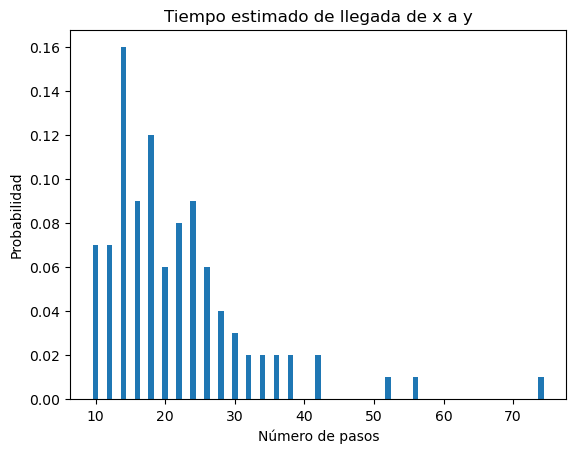

In [32]:
barras=pd.value_counts(tdl1) #Guardamos en un arreglo de pandas cuántas instancias de cada tiempo de llegada tenemos
plt.bar(x=barras.index,height=barras.values/barras.values.sum()) #Y lo graficamos
plt.title("Tiempo estimado de llegada de x a y")
plt.xlabel("Número de pasos")
plt.ylabel("Probabilidad")
plt.show()

Pero para pasar de $0$ a $1$ es de $1$, debido a que forzosamente tenemos que pasar por $1$ para continuar con la cadena.

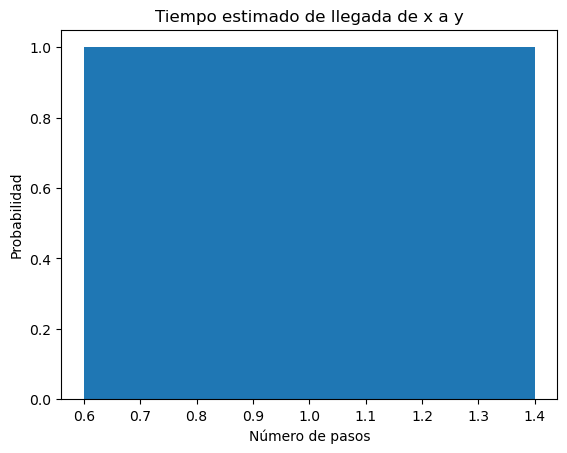

In [33]:
barras=pd.value_counts(tdl2) #Guardamos en un arreglo de pandas cuántas instancias de cada tiempo de llegada tenemos
plt.bar(x=barras.index,height=barras.values/barras.values.sum()) #Y lo graficamos
plt.title("Tiempo estimado de llegada de x a y")
plt.xlabel("Número de pasos")
plt.ylabel("Probabilidad")
plt.show()

### Clase de comunicación
A continuación veremos si dos estados se encuentran en la misma clase de comunicación. Para ello programamos una función que nos diga si un estado accede a otro. Hecho esto, la usamos para verificar que $x\to y$ y que $y\to x$. Si esto ocurre, entonces $x\longleftrightarrow y$.



In [37]:
#Función de acceso

def accede(x,y,n_sims):
    '''
    Recibe los estados enteros (x,y) y el ńumero de simulaciones a correr.
    Regresa un valor booleano indicando si x accede a y
    '''
    
    tdl = np.array(eta(x,y,100)) #Se obtiene una lista con los tiempos de llegada de cada una de las simulaciones
    
    if (tdl > 0).any(): #Si en cualquier caso es finito
        return True #Se accede
    else: #Si todo valor de los eta es 0 (infinito) se regresa falso
        return False
    
#Función de comunicación
def comunica(x,y,n_sims): 
    '''
    Recibimos dos estados (x,y) y vemos si uno accede al otro y el otro al uno. Aplicación directa de la función anterior
    '''
    if accede(x,y,n_sims) and accede(y,x,n_sims): #Si se acceden mutuamente, se comunican.
        return True
    
    else: #Si no, no se comunican.
        return False
    
print(accede(0,20,1000)) #Parece ser que el 0 no accede al 20.
print(comunica(0,1,100)) #Vemos que el 0 sí se comunica con el 1
print(comunica(0,20,100)) #Pero parece ser que el 0 y el 20 no se comunican.

False
True
False
